# Sportify client segmentation
This Data Science project aims at elucidating s sports items store about their clients regarding their digital social interactions, buying habits, and demographic data.  

The Project was carried out in April 2024 for the Data Science and Machine Learning Course of the Data Science Postgraduation of the NOVA Lisbon University, Portugal.  

**Authors:**  
Flávio Roberto Corte  
Luís Mourisco
Maria Delgado  
Nuno Machado  
Pedro Reis


# Import data

In [1]:
#import libraries
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from sklearn.impute import KNNImputer
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.decomposition import PCA
from sklearn.metrics.pairwise import euclidean_distances
from datetime import datetime
from scipy.cluster import hierarchy
from scipy.stats import boxcox
from scipy.stats import ttest_ind
from scipy import stats
from scipy.stats import f_oneway
from scipy.stats import chi2_contingency

# Digital Dataset

In [2]:
#import data
df_dig = pd.read_csv('data/Digital_Contact.csv', sep=';')

## Explore Data

In [3]:
df_dig.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4000 entries, 0 to 3999
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Cust_ID       4000 non-null   int64  
 1   Email_Clicks  4000 non-null   int64  
 2   SM_Comments   4000 non-null   int64  
 3   App_Clicks    4000 non-null   int64  
 4   SM_Likes      4000 non-null   int64  
 5   SM_Shares     3961 non-null   float64
 6   SM_Clicks     4000 non-null   int64  
dtypes: float64(1), int64(6)
memory usage: 218.9 KB


- Dtypes seem appropriate
- 4000 entries, only 39 SM_Shares have missing data

Initial Suggestions:  
- turn Cust_ID as index
- explore correlations between features: missing values in SM_Shares may not be relevant if other feature is highly correlated

In [4]:
df_dig.head()

,Cust_ID,Email_Clicks,SM_Comments,App_Clicks,SM_Likes,SM_Shares,SM_Clicks
0,4,72,1,7,7,1.0,73
1,5,15,20,1,35,15.0,16
2,6,9,7,3,73,19.0,10
3,9,67,0,2,0,1.0,101
4,10,38,0,1,9,0.0,56


In [5]:
#Cust_IDs are unique?
len(df_dig['Cust_ID'].unique())

4000

Yes, we can turn index as Cust_ID.

In [6]:
#Cust_ID as index
indices=df_dig['Cust_ID']
df_dig.set_index('Cust_ID', inplace=True)
df_dig.head(5)

,Email_Clicks,SM_Comments,App_Clicks,SM_Likes,SM_Shares,SM_Clicks
Cust_ID,,,,,,
4,72,1,7,7,1.0,73
5,15,20,1,35,15.0,16
6,9,7,3,73,19.0,10
9,67,0,2,0,1.0,101
10,38,0,1,9,0.0,56


In [7]:
#basic statistics
df_dig.describe()

,Email_Clicks,SM_Comments,App_Clicks,SM_Likes,SM_Shares,SM_Clicks
count,4000.00000,4000.000000,4000.000000,4000.000000,3961.000000,4000.000000
mean,25.76225,8.247750,19.526500,26.957000,8.355971,30.349250
std,23.65998,8.064963,34.237945,27.742658,8.696192,32.254974
min,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,8.00000,1.000000,2.000000,4.000000,1.000000,7.000000
50%,16.00000,4.000000,4.000000,11.000000,2.000000,15.000000
75%,36.00000,15.000000,7.000000,50.000000,16.000000,60.000000
max,86.00000,24.000000,127.000000,88.000000,26.000000,102.000000


All features seem to not be normally distributed, with values of mean around 2x the median - right tail.

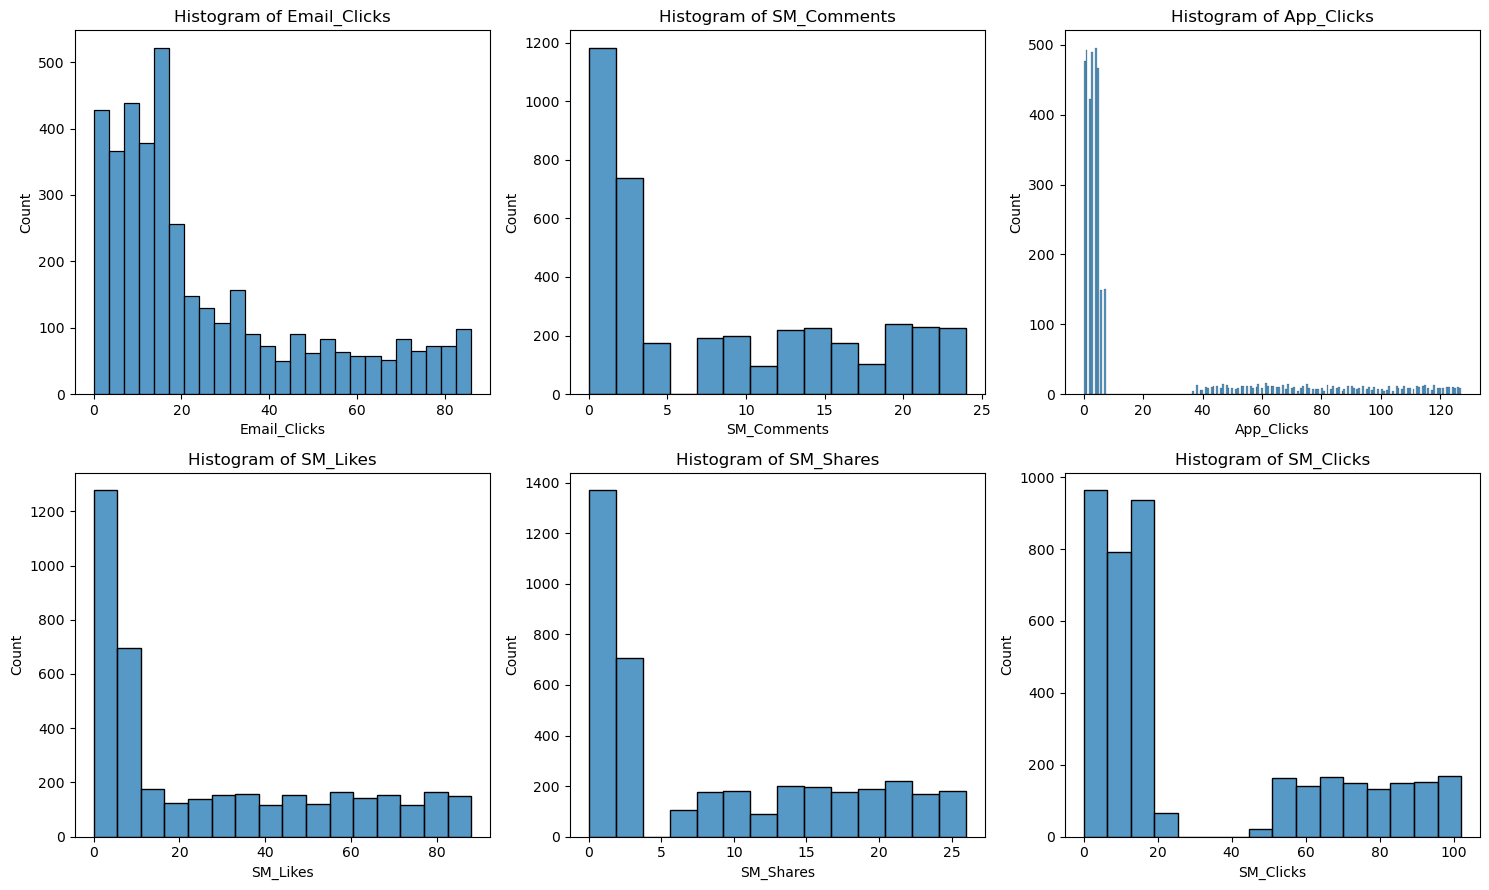

In [8]:
#look at distribution of values
fig, axes = plt.subplots(2, 3, figsize=(15, 9))  # Create a 2x3 grid of subplots
axes = axes.flatten()  # Flatten the 2D array of axes to iterate over it

for i, column in enumerate(df_dig.columns):
        sns.histplot(df_dig[column], ax=axes[i])
        axes[i].set_title(f'Histogram of {column}')

# Adjust layout and display the plot
plt.tight_layout()
plt.show()

There is mostly an tendency for a group of people to interact very little (the majority) with social apps, and other group with constant distribution over a range of values.  

The resemblance of SM_Comments with SM_Shares is striking. We should investigate this - and all correlations.

No outliers observed.

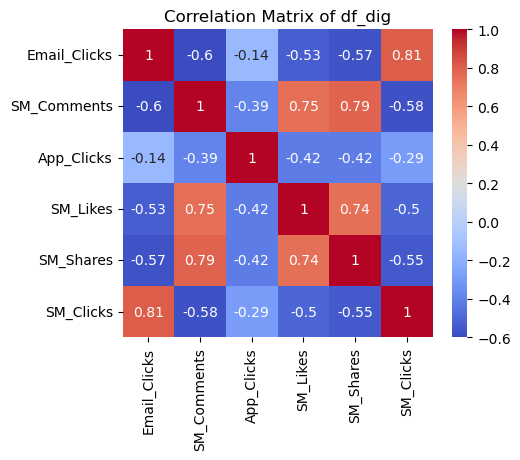

In [9]:
#correlatiomn between features
corr_matrix = df_dig.corr()
# Create a heatmap to visualize the correlation matrix
plt.figure(figsize=(5, 4))  # Set the size of the figure
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm')#, fmt=".2f", cmap='coolwarm', cbar=True, square=True)
plt.title('Correlation Matrix of df_dig')
plt.show()

There are some high correlations:
- **SM** interactions are highly correlated 0.74-0.79  
  - with a notable **exception**: moderare inverse correlation of **SM_clicks**  

    
- **Email_Clicks** is **inversely** correlated with **all** other features, except a high correlation with **SM_clicks**  

     
- **App_clicks** are generally moderately **inversely** correlated with **all** other features.   

## Fill empty values
The SM_Shares empty values represent less than 1% of the dataset's entries, and can be deleted without impact on the overall conclusions.  
However, we have strong indications, from the task's requests that the KNN usage is indeed usefull, hinting that the original data may have been deleted intentionally, and KNN may help recover it.  

Since the data is not normally distributes, neither with extended right or left tails, filling SM_Shares with the values of mean or median would result in artifacts in the data do not represent it. A KNN algorithm will be used to fill the null values in SM_Shares.

In [10]:
# Select the relevant columns for KNN Imputer
cols_para_imputer = ['SM_Shares', 'SM_Comments', 'SM_Likes', 'SM_Clicks', 'Email_Clicks', 'App_Clicks']

# Subset do DataFrame with relevant columns
df_para_imputer = df_dig[cols_para_imputer]
# Configure of imputer
imputer = KNNImputer(n_neighbors=5, weights='uniform')  # 'distance' também é uma opção
# Apply KNN Imputer, get matrix with filled values
df_imputed = imputer.fit_transform(df_para_imputer)

# convert to df
df_imputed = pd.DataFrame(df_imputed, columns=cols_para_imputer, index=df_dig.index)

# update original df
df_dig_clean = df_dig.copy()
df_dig_clean.update(df_imputed)  # Atualiza com os valores preenchidos

# round values to int
df_dig_clean['SM_Shares'] = df_dig_clean['SM_Shares'].round().astype('int')

print('Nr. of empty values:')
df_dig_clean.isna().sum()

Nr. of empty values:


Email_Clicks    0
SM_Comments     0
App_Clicks      0
SM_Likes        0
SM_Shares       0
SM_Clicks       0
dtype: int64

In [11]:
df_dig_clean.head()

,Email_Clicks,SM_Comments,App_Clicks,SM_Likes,SM_Shares,SM_Clicks
Cust_ID,,,,,,
4,72,1,7,7,1,73
5,15,20,1,35,15,16
6,9,7,3,73,19,10
9,67,0,2,0,1,101
10,38,0,1,9,0,56


All empty entries were filled.

### Fill with KNN - comapare 4 vs 6 columns

In [12]:
# Select the relevant columns for KNN Imputer
cols_para_imputer2 = ['SM_Shares', 'SM_Comments', 'SM_Likes', 'SM_Clicks']

# Subset do DataFrame with relevant columns
df_para_imputer2 = df_dig[cols_para_imputer2]
# Configure of imputer
imputer2 = KNNImputer(n_neighbors=5, weights='uniform')  # 'distance' também é uma opção
# Apply KNN Imputer, get matrix with filled values
df_imputed2 = imputer2.fit_transform(df_para_imputer2)

# convert to df
df_imputed2 = pd.DataFrame(df_imputed2, columns=cols_para_imputer2, index=df_dig.index)

# update original df
df_dig2 = df_dig.copy()
df_dig2.update(df_imputed2)  # Atualiza com os valores preenchidos

# round values to int
df_dig2['SM_Shares'] = df_dig2['SM_Shares'].round().astype('int')

print('Nr. of empty values:')
df_dig2.isna().sum()

Nr. of empty values:


Email_Clicks    0
SM_Comments     0
App_Clicks      0
SM_Likes        0
SM_Shares       0
SM_Clicks       0
dtype: int64

In [13]:
#compare both versions
(df_dig2['SM_Shares'] != df_dig_clean['SM_Shares']).sum()

16

Either using all columns, or only SM columns, the result is the same.  

## Feature Reduction and Feature Scaling
one or two SM features?
(Variance Explained: Consider how much of the variance in your dataset is explained by these features. Sometimes, despite high correlation, both features might capture different aspects that are critical for clustering.)

**Two aproaches to compare for reducing dimensionality:**
1) delete two of the the correlated SM columns and keep one (Shares, Likes, and Comments)
2) put the three together into one new column (after normalization)
   - keeps all the information with less noise
   - more difficult to interpret beyond ('social interaction')


### DF Zero: df as is

In [14]:
df_dig_clean.head()

,Email_Clicks,SM_Comments,App_Clicks,SM_Likes,SM_Shares,SM_Clicks
Cust_ID,,,,,,
4,72,1,7,7,1,73
5,15,20,1,35,15,16
6,9,7,3,73,19,10
9,67,0,2,0,1,101
10,38,0,1,9,0,56


In [15]:
#scale features
scaler_zero = StandardScaler()
df_dig_zero_scaled = pd.DataFrame(scaler_zero.fit_transform(df_dig_clean), columns = df_dig.columns) #applied to all columns because all are numeric
df_dig_zero_scaled.index=df_dig_clean.index
df_dig_zero_scaled.head()

,Email_Clicks,SM_Comments,App_Clicks,SM_Likes,SM_Shares,SM_Clicks
Cust_ID,,,,,,
4,1.954504,-0.898784,-0.365912,-0.719451,-0.846507,1.322465
5,-0.454928,1.457380,-0.541178,0.289951,0.764408,-0.444925
6,-0.708553,-0.154732,-0.482756,1.659854,1.224669,-0.630966
9,1.743150,-1.022792,-0.511967,-0.971802,-0.846507,2.190657
10,0.517299,-1.022792,-0.541178,-0.647351,-0.961573,0.795349


### DF One: two SM columns less
The correlation between SM_Comments and SM_Shares is not high enough so that we can eliminate the SM_Shares feature.
Among Shares, Likes, and Comments, Shares has missing values and should be eliminated.  

Between Comments and Likes, Comments keeps a higher correlation with the eliminated Shares column, thus Comments will be kept as representative of the SM interactions.

In [16]:
#new option 1 df:
df_dig_one=df_dig.drop(['SM_Shares','SM_Likes'], axis=1)
df_dig_one.head()

,Email_Clicks,SM_Comments,App_Clicks,SM_Clicks
Cust_ID,,,,
4,72,1,7,73
5,15,20,1,16
6,9,7,3,10
9,67,0,2,101
10,38,0,1,56


In [17]:
#scale features
scaler_one = StandardScaler()
df_dig_one_scaled = pd.DataFrame(scaler_one.fit_transform(df_dig_one), columns = df_dig_one.columns) #applied to all columns because all are numeric
df_dig_one_scaled.head()

,Email_Clicks,SM_Comments,App_Clicks,SM_Clicks
0,1.954504,-0.898784,-0.365912,1.322465
1,-0.454928,1.457380,-0.541178,-0.444925
2,-0.708553,-0.154732,-0.482756,-0.630966
3,1.743150,-1.022792,-0.511967,2.190657
4,0.517299,-1.022792,-0.541178,0.795349


### DF Two: pull three SM columns into one
SM_shares, SM_likes, and SM_comments

In [18]:
#percentage of SM_Shares null values
df_dig['SM_Shares'].isnull().mean()

0.00975

Less than 1% of values of SM_Shares are missing. Given the apparent existence of at least two populations, neither the mean or the median would be suitable to fill missing values. Other features do not allow a good estimation of the missing values.  
Since the missing values represent such a low proportion of the populations let's eliminate them.

In [19]:
#scale features
scaler_two = StandardScaler()
df_dig_two_scaled = pd.DataFrame(scaler_two.fit_transform(df_dig_clean), columns = df_dig_clean.columns) #applied to all columns because all are numeric
df_dig_two_scaled.head()

,Email_Clicks,SM_Comments,App_Clicks,SM_Likes,SM_Shares,SM_Clicks
0,1.954504,-0.898784,-0.365912,-0.719451,-0.846507,1.322465
1,-0.454928,1.457380,-0.541178,0.289951,0.764408,-0.444925
2,-0.708553,-0.154732,-0.482756,1.659854,1.224669,-0.630966
3,1.743150,-1.022792,-0.511967,-0.971802,-0.846507,2.190657
4,0.517299,-1.022792,-0.541178,-0.647351,-0.961573,0.795349


In [20]:
#pull Shares, Likes, and Comments into Interactions
df_dig_two_scaled['SM_interactions'] = df_dig_two_scaled[['SM_Comments', 'SM_Likes', 'SM_Shares']].mean(axis=1)
df_dig_two_scaled.head()

,Email_Clicks,SM_Comments,App_Clicks,SM_Likes,SM_Shares,SM_Clicks,SM_interactions
0,1.954504,-0.898784,-0.365912,-0.719451,-0.846507,1.322465,-0.821581
1,-0.454928,1.457380,-0.541178,0.289951,0.764408,-0.444925,0.837246
2,-0.708553,-0.154732,-0.482756,1.659854,1.224669,-0.630966,0.909931
3,1.743150,-1.022792,-0.511967,-0.971802,-0.846507,2.190657,-0.947034
4,0.517299,-1.022792,-0.541178,-0.647351,-0.961573,0.795349,-0.877239


In [21]:
df_dig_two_scaled.drop(['SM_Comments', 'SM_Likes', 'SM_Shares'], axis=1, inplace=True)
df_dig_two_scaled.head()

,Email_Clicks,App_Clicks,SM_Clicks,SM_interactions
0,1.954504,-0.365912,1.322465,-0.821581
1,-0.454928,-0.541178,-0.444925,0.837246
2,-0.708553,-0.482756,-0.630966,0.909931
3,1.743150,-0.511967,2.190657,-0.947034
4,0.517299,-0.541178,0.795349,-0.877239


## Determine Optimal Number of Clusters
Elbow Method, Silhouette Score, or the Gap Statistic

### Option Zero

In [22]:
df_dig_zero_scaled.info()

<class 'pandas.core.frame.DataFrame'>
Index: 4000 entries, 4 to 6496
Data columns (total 6 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Email_Clicks  4000 non-null   float64
 1   SM_Comments   4000 non-null   float64
 2   App_Clicks    4000 non-null   float64
 3   SM_Likes      4000 non-null   float64
 4   SM_Shares     4000 non-null   float64
 5   SM_Clicks     4000 non-null   float64
dtypes: float64(6)
memory usage: 218.8 KB


C:\Users\nihon\anaconda3\envs\ds\Lib\site-packages\joblib\externals\loky\backend\context.py:136: UserWarning: Could not find the number of physical cores for the following reason:
[WinError 2] The system cannot find the file specified
Returning the number of logical cores instead. You can silence this warning by setting LOKY_MAX_CPU_COUNT to the number of cores you want to use.
  warnings.warn(
  File "C:\Users\nihon\anaconda3\envs\ds\Lib\site-packages\joblib\externals\loky\backend\context.py", line 257, in _count_physical_cores
    cpu_info = subprocess.run(
               ^^^^^^^^^^^^^^^
  File "C:\Users\nihon\anaconda3\envs\ds\Lib\subprocess.py", line 548, in run
    with Popen(*popenargs, **kwargs) as process:
         ^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\nihon\anaconda3\envs\ds\Lib\subprocess.py", line 1026, in __init__
    self._execute_child(args, executable, preexec_fn, close_fds,
  File "C:\Users\nihon\anaconda3\envs\ds\Lib\subprocess.py", line 1538, in _execute_child


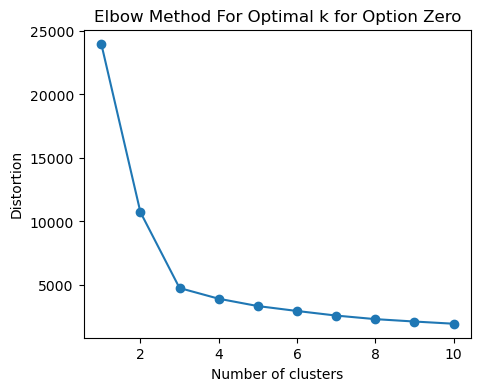

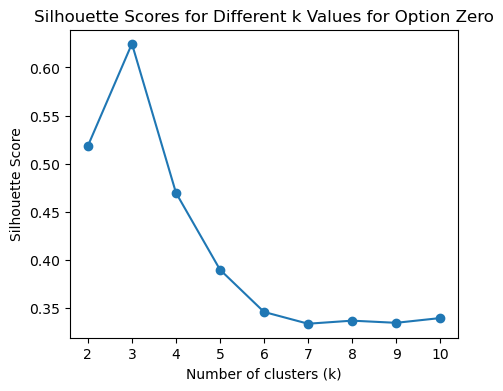

In [23]:
# Calculate distortion for a range of number of cluster
distortions_zero = [] #for elbow method

#for silhouette method
features_zero = df_dig_zero_scaled
silhouette_scores_digital_zero = []

#calculate relevant measurements for both elbow and silhouette methods
for i in range(1, 11):
    km_zero = KMeans(n_clusters=i, init='k-means++', n_init=10, max_iter=300, random_state=42) #kmean++ to get a better spreading of the initial centroids
    cluster_labels_zero = km_zero.fit_predict(features_zero)  # Fit and predict simultaneously
    #calculate inertia score
    distortions_zero.append(km_zero.inertia_)

    # Calculate silhouette scores
    if i > 1:
        silhouette_avg = silhouette_score(features_zero, cluster_labels_zero)
        silhouette_scores_digital_zero.append(silhouette_avg)

# Plot the elbow graph
plt.figure(figsize=(5, 4))
plt.plot(range(1, 11), distortions_zero, marker='o')
plt.title('Elbow Method For Optimal k for Option Zero')
plt.xlabel('Number of clusters')
plt.ylabel('Distortion')
plt.show()

# Plot the silhouette scores, note the range adjustment for x-axis
if len(silhouette_scores_digital_zero) > 0:  # Check if list is not empty
    plt.figure(figsize=(5, 4))
    plt.plot(range(2, 11), silhouette_scores_digital_zero, marker='o')
    plt.title('Silhouette Scores for Different k Values for Option Zero')
    plt.xlabel('Number of clusters (k)')
    plt.ylabel('Silhouette Score')
    plt.show()

Best  nr of clusters is 3.

### Option One:

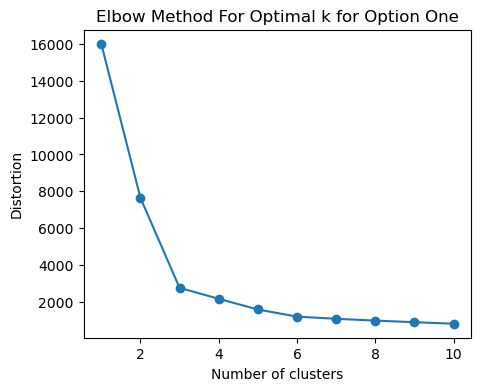

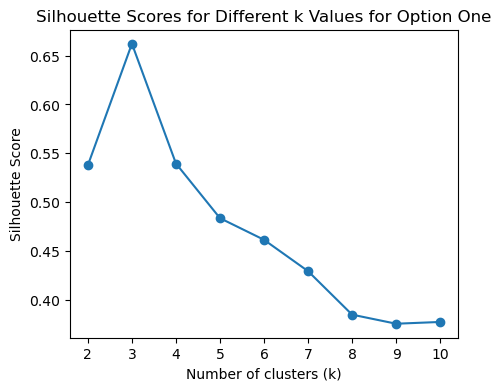

In [24]:
# Calculate distortion for a range of number of cluster
distortions_one = [] #for elbow method

#for silhouette method
features_one = df_dig_one_scaled
silhouette_scores_digital_one = []

#calculate relevant measurements for both elbow and silhouette methods
for i in range(1, 11):
    km_one = KMeans(n_clusters=i, init='k-means++', n_init=10, max_iter=300, random_state=42) #kmean++ to get a better spreading of the initial centroids
    cluster_labels_one = km_one.fit_predict(features_one)  # Fit and predict simultaneously
    #calculate inertia score
    distortions_one.append(km_one.inertia_)

    # Calculate silhouette scores
    if i > 1:
        silhouette_avg = silhouette_score(features_one, cluster_labels_one)
        silhouette_scores_digital_one.append(silhouette_avg)

# Plot the elbow graph
plt.figure(figsize=(5, 4))
plt.plot(range(1, 11), distortions_one, marker='o')
plt.title('Elbow Method For Optimal k for Option One')
plt.xlabel('Number of clusters')
plt.ylabel('Distortion')
plt.show()

# Plot the silhouette scores, note the range adjustment for x-axis
if len(silhouette_scores_digital_one) > 0:  # Check if list is not empty
    plt.figure(figsize=(5, 4))
    plt.plot(range(2, 11), silhouette_scores_digital_one, marker='o')
    plt.title('Silhouette Scores for Different k Values for Option One')
    plt.xlabel('Number of clusters (k)')
    plt.ylabel('Silhouette Score')
    plt.show()

**3 clusters** are ideal to characterize our data. (option one)

### Option Two

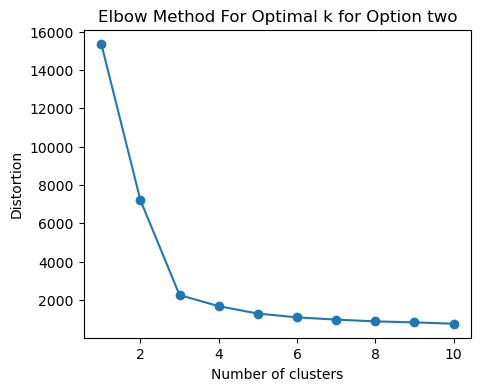

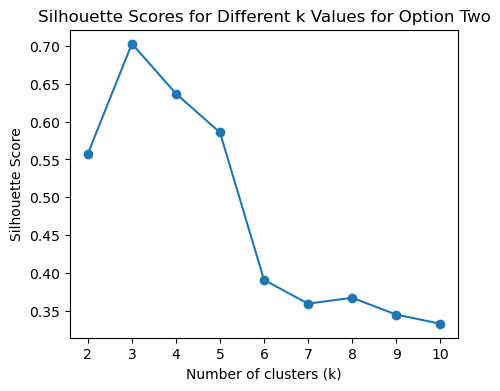

In [25]:
# Calculate distortion for a range of number of cluster
distortions_two = [] #for elbow method

#for silhouette method
features_two = df_dig_two_scaled
silhouette_scores_digital_two = []

#calculate relevant measurements for both elbow and silhouette methods
for i in range(1, 11):
    km_two = KMeans(n_clusters=i, init='k-means++', n_init=10, max_iter=300, random_state=42) #kmean++ to get a better spreading of the initial centroids
    cluster_labels_two = km_two.fit_predict(features_two)  # Fit and predict simultaneously
    #calculate inertia score
    distortions_two.append(km_two.inertia_)

    # Calculate silhouette scores
    if i > 1:
        silhouette_avg = silhouette_score(features_two, cluster_labels_two)
        silhouette_scores_digital_two.append(silhouette_avg)

# Plot the elbow graph
plt.figure(figsize=(5, 4))
plt.plot(range(1, 11), distortions_two, marker='o')
plt.title('Elbow Method For Optimal k for Option two')
plt.xlabel('Number of clusters')
plt.ylabel('Distortion')
plt.show()

# Plot the silhouette scores, note the range adjustment for x-axis
if len(silhouette_scores_digital_two) > 0:  # Check if list is not empty
    plt.figure(figsize=(5, 4))
    plt.plot(range(2, 11), silhouette_scores_digital_two, marker='o')
    plt.title('Silhouette Scores for Different k Values for Option Two')
    plt.xlabel('Number of clusters (k)')
    plt.ylabel('Silhouette Score')
    plt.show()

**3 clusters** is also ideal for option Two.

- **Option Zero** clusters seem to represent better the data with lower distances beteween data in each cluster: 2232 vs 2762.

## K-Means Clustering

#Option Zero
n_clusters=3
km_zero_final = KMeans(n_clusters=n_clusters, init='k-means++', n_init=10, max_iter=300, random_state=42)
km_zero_final.fit(df_dig_zero_scaled)
df_dig_zero_scaled['cluster'] = pd.Series(km_zero_final.predict(df_dig_zero_scaled))
df_dig_zero_scaled.head()

#look at each cluster's data
for i in range(n_clusters):
    print(f'cluster: {i}')
    plt.figure(figsize=(5, 3))
    sns.boxplot(data=df_dig_zero_scaled[df_dig_zero_scaled['cluster'] == i].iloc[:,0:-1])
    plt.title('')
    plt.show()

**values for cluster**

In [26]:
#create column to store scores of k=3 after kmneans
distortions = [distortions_zero[2], distortions_one[2], distortions_two[2]]
silhouette_scores = [silhouette_scores_digital_zero[1], silhouette_scores_digital_one[1], silhouette_scores_digital_two[1]] 

scores_kmeans = {'distortion': distortions, 'silhouette_score': silhouette_scores}

df_scores_kmeans = pd.DataFrame(data=scores_kmeans)
df_scores_kmeans


,distortion,silhouette_score
0,4752.322811,0.624604
1,2766.588088,0.662143
2,2254.958204,0.702768


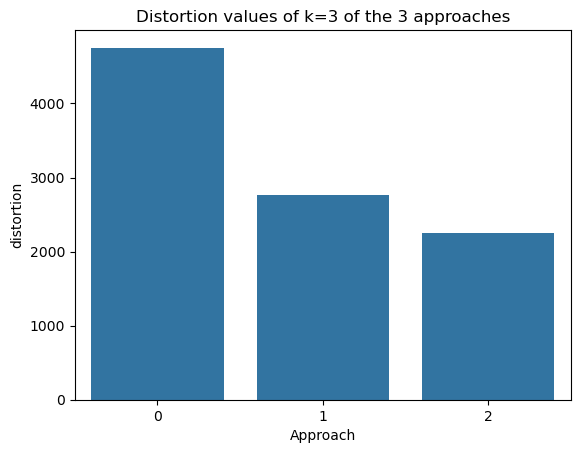

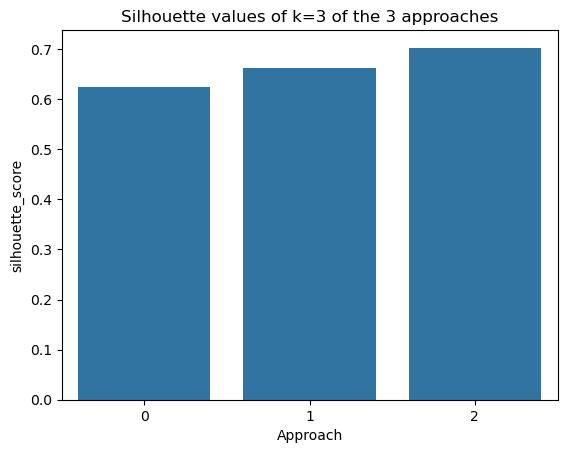

In [27]:
#graph for distortions
sns.barplot(data=df_scores_kmeans['distortion'])
plt.title('Distortion values of k=3 of the 3 approaches')
plt.xlabel('Approach')
plt.show()
#graph for silhouettes
sns.barplot(data=df_scores_kmeans['silhouette_score'])
plt.title('Silhouette values of k=3 of the 3 approaches')
plt.xlabel('Approach')
plt.show()

### Option Zero

In [28]:
#Option Zero
n_clusters=3
km_zero_final = KMeans(n_clusters=n_clusters, init='k-means++', n_init=10, max_iter=300, random_state=42)
km_zero_final.fit(df_dig_zero_scaled)
df_dig_zero_scaled['cluster'] = pd.Series(km_zero_final.predict(df_dig_zero_scaled))
df_dig_zero_scaled.head()

,Email_Clicks,SM_Comments,App_Clicks,SM_Likes,SM_Shares,SM_Clicks,cluster
Cust_ID,,,,,,,
4,1.954504,-0.898784,-0.365912,-0.719451,-0.846507,1.322465,2.0
5,-0.454928,1.457380,-0.541178,0.289951,0.764408,-0.444925,2.0
6,-0.708553,-0.154732,-0.482756,1.659854,1.224669,-0.630966,1.0
9,1.743150,-1.022792,-0.511967,-0.971802,-0.846507,2.190657,1.0
10,0.517299,-1.022792,-0.541178,-0.647351,-0.961573,0.795349,2.0


In [29]:
df_dig_zero_scaled.groupby('cluster')['cluster'].count()

cluster
0.0     529
1.0    1171
2.0     770
Name: cluster, dtype: int64

Cluster 0


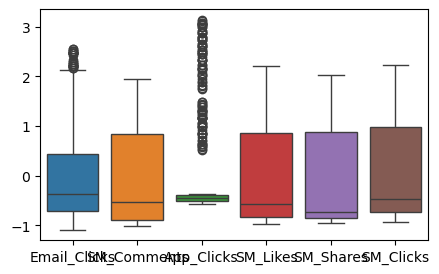

Cluster 1


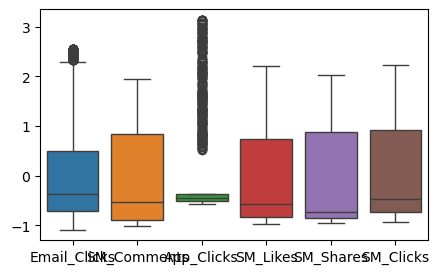

Cluster 2


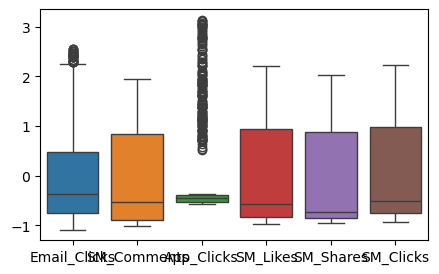

In [30]:
#look at each cluster's data
for i in range(n_clusters):
    print(f'Cluster {i}')
    plt.figure(figsize=(5, 3))
    sns.boxplot(data=df_dig_zero_scaled[df_dig_zero_scaled['cluster'] == i].iloc[:,0:-1])
    plt.title('')
    plt.show()

The 3 cluster have 3 well defined behaviors:
- App users
- Pub clickers
- SM posts interaction / Social Butterflies

The 3 cluster have 3 well defined behaviors:
1) The 'high commenters', with **SM_Comments** being the only feature above average (and the other two gighly correlated, deleted features)
2) The 'social clickers', with **Email_clicks** and **SM_Clicks** above average.
3) The 'app clickers', with **App_clicks** above average.

### Arrange clusters numbers for consistency - in progress

df_dig_zero_scaled.groupby('cluster')['App_Clicks'].mean().idxmax()

#get cluster numbers

#social butterflies (willl be 0)
social_butterflies = df_dig_zero_scaled.groupby('cluster')['SM_Shares'].mean().idxmax()
print(social_butterflies)

#clickers (will be 1)
clickers = df_dig_zero_scaled.groupby('cluster')['Email_Clicks'].mean().idxmax()
print(clickers)

#app users will be 2
app_users = df_dig_zero_scaled.groupby('cluster')['App_Clicks'].mean().idxmax()
print(app_users)

#assign new numbers to clusters

#create a dictionary with new labels
new_labels = {
    social_butterflies: 0,
    clickers: 1,
    app_users: 2
}

#column with the new cluster labels
df_dig_zero_scaled['new_cluster'] = np.select(
    [
        df_dig_zero_scaled['cluster'] == social_butterflies,
        df_dig_zero_scaled['cluster'] == clickers,
        df_dig_zero_scaled['cluster'] == app_users
    ],
    [
        new_labels[social_butterflies],
        new_labels[clickers],
        new_labels[app_users]
    ],
    default=3  #default value if none of the conditions above are met
)


clusters_only = df_dig_zero_scaled[['cluster', 'new_cluster']]


#check count
clusters_only.groupby('cluster')['cluster'].count()

clusters_only.groupby('new_cluster')['cluster'].count()

#assign new clister labels
df_dig_zero_scaled['cluster'] = df_dig_zero_scaled['new_cluster']
df_dig_zero_scaled = df_dig_zero_scaled.drop('new_cluster', axis=1)
df_dig_zero_scaled.head()

## Export files to compare to other DFs

In [31]:
#export final df with original cleaned data and a column with clusters
#df_dig_zero_scaled.index=indices
#df_dig_zero_scaled.to_csv('data/df_dig_zero_scaled.csv', index=True) #includes indices

df_dig_clean['cluster']=km_zero_final.labels_
df_dig_clean
#df_dig_clean.isna().sum()


df_dig_clean.to_csv('exported_data/df_dig_clean.csv', index=True)
#export cluster's quality measurement
#df_scores_kmeans.to_csv('df_scores_kmeans.csv', index=True) #includes indices

## PCA analysis

In [32]:
df_dig_clean2 = df_dig_clean.drop('cluster', axis=1)

In [33]:
#scale data before performing PCA
scaler=StandardScaler()
df_dig_std=pd.DataFrame(scaler.fit_transform(df_dig_clean2), columns=df_dig.columns)
df_dig_std.index = df_dig.index
df_dig_std.head()

,Email_Clicks,SM_Comments,App_Clicks,SM_Likes,SM_Shares,SM_Clicks
Cust_ID,,,,,,
4,1.954504,-0.898784,-0.365912,-0.719451,-0.846507,1.322465
5,-0.454928,1.457380,-0.541178,0.289951,0.764408,-0.444925
6,-0.708553,-0.154732,-0.482756,1.659854,1.224669,-0.630966
9,1.743150,-1.022792,-0.511967,-0.971802,-0.846507,2.190657
10,0.517299,-1.022792,-0.541178,-0.647351,-0.961573,0.795349


In [34]:
#explore how much variance each PC captures
nr_features = df_dig_std.shape[1]
pca = PCA(n_components=nr_features)
df_dig_std_trans= pd.DataFrame(pca.fit_transform(df_dig_std))
df_dig_std_trans.head()

,0,1,2,3,4,5
0,-2.428741,-1.225402,0.201158,-0.540518,0.032379,-0.104025
1,1.626042,-0.403463,-0.539964,-0.268084,-0.559794,0.080899
2,1.866093,-0.309298,0.750337,0.330047,1.072342,-0.110763
3,-2.837209,-1.595188,-0.073097,-0.073472,0.063200,0.444548
4,-1.675945,-0.541437,0.020522,0.586268,0.008566,-0.369716


In [35]:
#recover index values
df_dig_std_trans.index = df_dig_clean.index
df_dig_std_trans.head()

,0,1,2,3,4,5
Cust_ID,,,,,,
4,-2.428741,-1.225402,0.201158,-0.540518,0.032379,-0.104025
5,1.626042,-0.403463,-0.539964,-0.268084,-0.559794,0.080899
6,1.866093,-0.309298,0.750337,0.330047,1.072342,-0.110763
9,-2.837209,-1.595188,-0.073097,-0.073472,0.063200,0.444548
10,-1.675945,-0.541437,0.020522,0.586268,0.008566,-0.369716


In [36]:
# Print the results
print('PCA Summary')
print('No. of features: ', df_dig_std_trans.shape[1])
print('No. of samples: ', df_dig_std_trans.shape[0])
print('No. of components: ', pca.n_components_)
print('Explained variance ratio: ', pca.explained_variance_ratio_)


PCA Summary
No. of features:  6
No. of samples:  4000
No. of components:  6
Explained variance ratio:  [0.60586862 0.25640614 0.04455278 0.03773459 0.03447368 0.02096419]


In [37]:
#let's analyze how many components we should keep
#plot cumulative explained variance
cum_variance=[]
for i, value in enumerate(pca.explained_variance_ratio_):
    if i==0:
        cum_variance.append(value)
    else:
        cum_variance.append(value+cum_variance[i-1])
print('Cumulative variance ratio over PCs: ', cum_variance)

Cumulative variance ratio over PCs:  [0.6058686199346819, 0.8622747618722323, 0.9068275444444206, 0.9445621339396784, 0.9790358125715996, 1.0000000000000002]


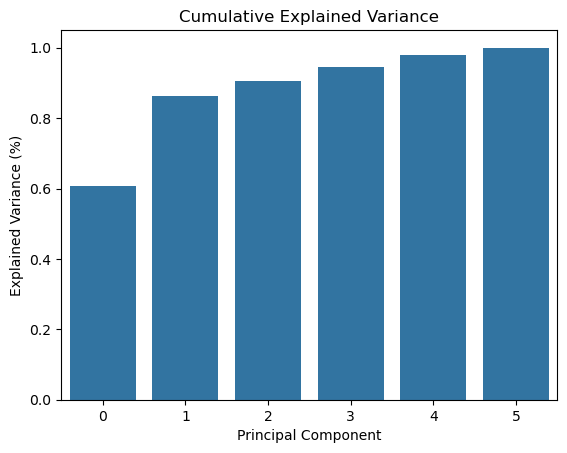

In [38]:
#Graphical representation of PCs' cumulative variance ratio
sns.barplot(data=cum_variance)
plt.title('Cumulative Explained Variance')
plt.xlabel('Principal Component')
plt.ylabel('Explained Variance (%)')
plt.show()

With only **3 components** we get more than **90% of the explained variance**.

In [39]:
#PCA with 3 components
n_components=2
pca_final = PCA(n_components=n_components)
df_dig_std_transfinal= pd.DataFrame(pca_final.fit_transform(df_dig_std))

df_dig_std_transfinal.index = df_dig_clean.index
df_dig_std_transfinal.columns += 1
df_dig_std_transfinal.head()

,1,2
Cust_ID,,
4,-2.428741,-1.225402
5,1.626042,-0.403463
6,1.866093,-0.309298
9,-2.837209,-1.595188
10,-1.675945,-0.541437


<Axes: ylabel='Count'>

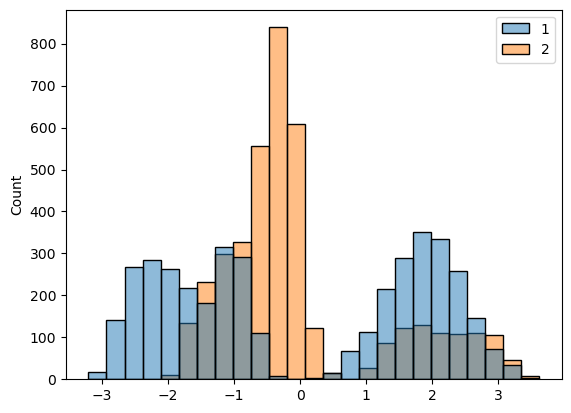

In [40]:
#look at data distribution
sns.histplot(data=df_dig_std_transfinal)

Components 1 and 2 are distributed over two populations - as observed in the original data.  

K-means is not the appropriate clustering algorithm as it is better for data distributed in a globular manner.  

But let's confirm that with numbers...

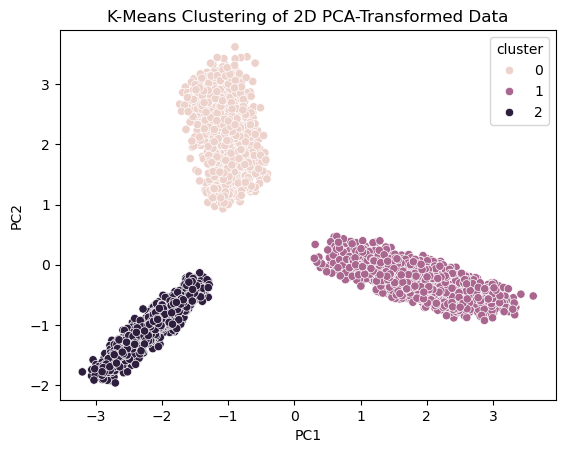

In [41]:
#look at clusters in 2D, with clustering with 2 components
sns.scatterplot(data=df_dig_std_transfinal, x=df_dig_std_transfinal[1], y=df_dig_std_transfinal[2], hue=df_dig_clean['cluster'])
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.title('K-Means Clustering of 2D PCA-Transformed Data')
plt.show()

# Products Dataset

## Import data from file

In [42]:
#import data
Products=pd.read_excel("data/Products.xlsx")
Products.set_index('Cust_ID', inplace = True)
Products.head()

,Fitness&Gym,Hiking&Running,Last_Purchase,TeamGames,OutdoorActivities,TotalProducts
Cust_ID,,,,,,
4,0,76,2024-02-19,248,37,6
5,0,75,2024-02-17,248,37,6
6,6,69,2024-02-15,215,34,5
9,36,71,2024-02-13,248,35,8
10,8,97,2024-02-15,204,34,5


In [43]:
#search duplicates
len(Products[Products.duplicated()])

510

There are 510 duplicates.  

However, there is no reason to exclude them when the feedback we get is that the data's integrity is of the highst quality and all IDs (common with other two datasets are unique. It could be a specific promotion, for example.

In [44]:
#confirm uniqueness of IDs
len(Products.index.unique())

4000

In [45]:
#make column names better with snake_case
Products.columns = Products.columns.str.lower().str.replace('&','_')
Products.columns

Index(['fitness_gym', 'hiking_running', 'last_purchase', 'teamgames',
       'outdooractivities', 'totalproducts'],
      dtype='object')

## DF exploration

In [46]:
Products.info()

<class 'pandas.core.frame.DataFrame'>
Index: 4000 entries, 4 to 6496
Data columns (total 6 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   fitness_gym        4000 non-null   int64         
 1   hiking_running     4000 non-null   int64         
 2   last_purchase      4000 non-null   datetime64[ns]
 3   teamgames          4000 non-null   int64         
 4   outdooractivities  4000 non-null   int64         
 5   totalproducts      4000 non-null   int64         
dtypes: datetime64[ns](1), int64(5)
memory usage: 347.8 KB


All value types seem correct. No null values.

In [47]:
Products.describe()

,fitness_gym,hiking_running,last_purchase,teamgames,outdooractivities,totalproducts
count,4000.000000,4000.000000,4000,4000.000000,4000.000000,4000.000000
mean,32.020250,55.844750,2024-01-30 18:50:02.399999744,176.085000,33.602750,5.329500
min,0.000000,9.000000,2023-10-15 00:00:00,0.000000,28.000000,2.000000
25%,25.000000,38.000000,2024-01-20 00:00:00,121.000000,32.000000,4.000000
50%,31.000000,47.000000,2024-02-01 00:00:00,180.000000,33.000000,5.000000
75%,40.000000,66.000000,2024-02-13 00:00:00,230.000000,35.000000,6.000000
max,123.000000,464.000000,2024-02-29 00:00:00,1203.000000,42.000000,20.000000
std,14.469284,33.119109,NaN,69.964738,1.711483,1.515257


All features have median and mean values close together, suggesting gaussian distribution data.  

Let's confirm.

In [48]:
#check skewness of data
numeric=['fitness_gym', 'hiking_running', 'teamgames', 'outdooractivities', 'totalproducts']
Products[numeric].skew()

fitness_gym          0.346342
hiking_running       4.671687
teamgames            0.740859
outdooractivities    0.414896
totalproducts        1.791119
dtype: float64

hiking_running and totalproducts  are highly positively skewed.  
teamgames is moderately skewed.


In [49]:
Products[numeric].kurt()

fitness_gym           1.464810
hiking_running       37.839539
teamgames            10.605494
outdooractivities     0.399144
totalproducts         9.247286
dtype: float64

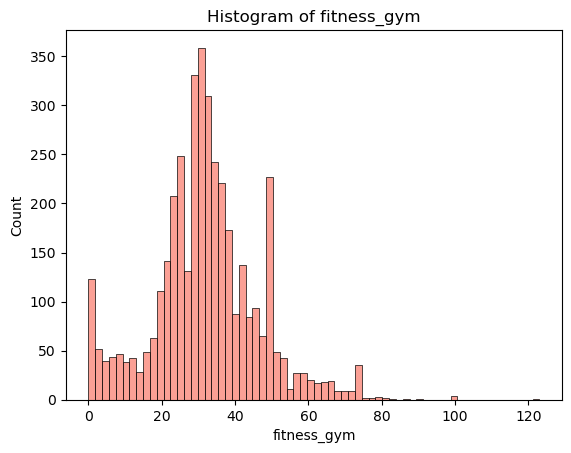

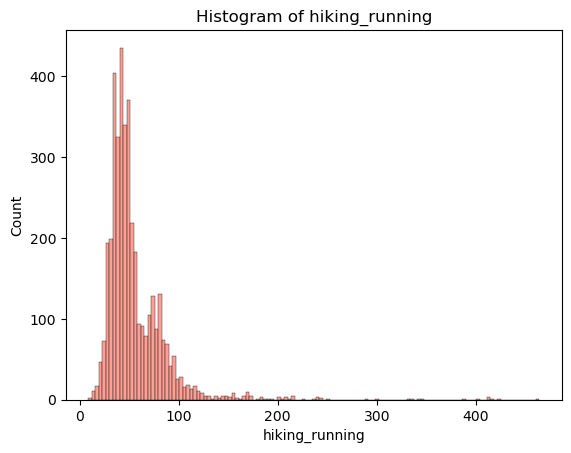

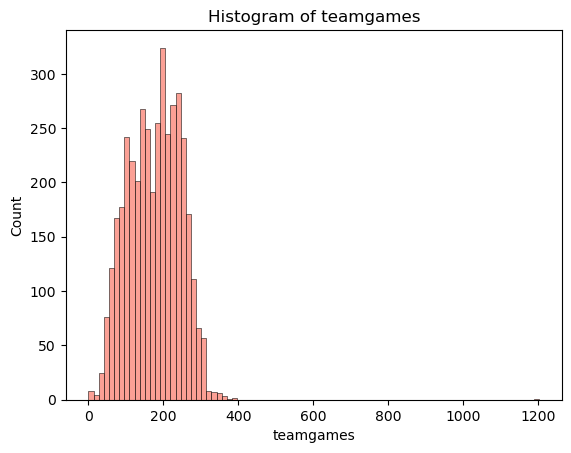

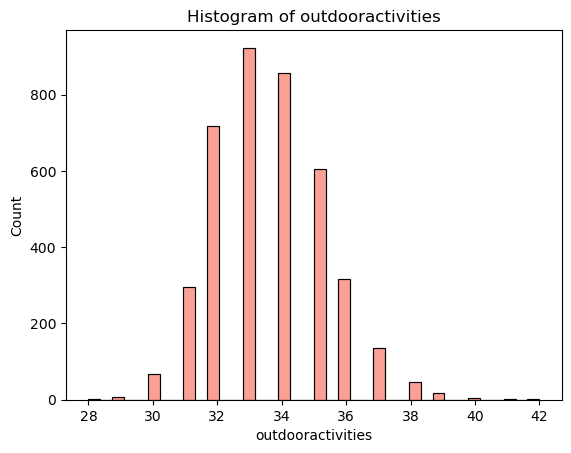

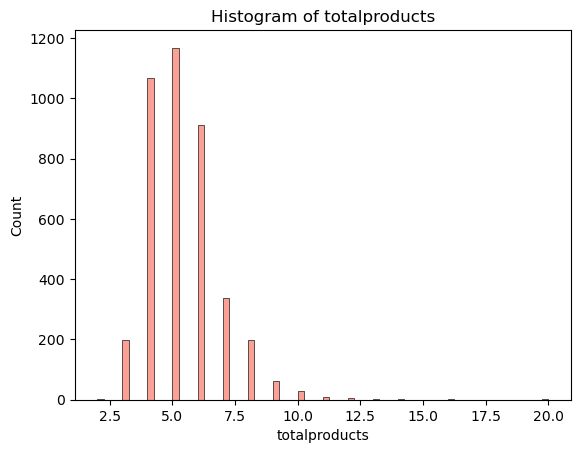

In [50]:
#check distributions
for column in Products[numeric].columns:
    sns.histplot(data=Products, x=column, color="salmon")
    plt.title(f'Histogram of {column}')
    plt.show()

## Preprocessing

No Df Products, criaremos:
1) Coluna de Total de Gasto,
2) Gasto médio por produto e
3) Trocamos data de última compra por #dias desde da última compra (assumindo 21-04-2024)
4) Removemos os duplicados
5) Deixar cair a coluna 'TotalProducts' porque não dá grande informação.

In [51]:
# Criar a nova coluna "total_spent" com a soma das colunas especificadas
spending=['fitness_gym', 'hiking_running', 'teamgames', 'outdooractivities']
Products['total_spent'] = Products[spending].sum(axis=1)
Products.head()                                                   

,fitness_gym,hiking_running,last_purchase,teamgames,outdooractivities,totalproducts,total_spent
Cust_ID,,,,,,,
4,0,76,2024-02-19,248,37,6,361
5,0,75,2024-02-17,248,37,6,360
6,6,69,2024-02-15,215,34,5,324
9,36,71,2024-02-13,248,35,8,390
10,8,97,2024-02-15,204,34,5,343


In [52]:
#criar coluna de average spending
Products['Avg_Spent']=Products['total_spent']/Products['totalproducts']
Products['Avg_Spent'] = np.ceil(Products['Avg_Spent'])  # Arredondar para cima
Products['Avg_Spent']=Products['Avg_Spent'].astype(int)
Products.head()

,fitness_gym,hiking_running,last_purchase,teamgames,outdooractivities,totalproducts,total_spent,Avg_Spent
Cust_ID,,,,,,,,
4,0,76,2024-02-19,248,37,6,361,61
5,0,75,2024-02-17,248,37,6,360,60
6,6,69,2024-02-15,215,34,5,324,65
9,36,71,2024-02-13,248,35,8,390,49
10,8,97,2024-02-15,204,34,5,343,69


In [53]:
#get number of days since last purchase
Products['last_purchase'] = pd.to_datetime(Products['last_purchase'])
today = pd.Timestamp(datetime.today().date())  # ou pd.Timestamp('today')
Products['Days_Since_Last_Purchase'] = (today - Products['last_purchase']).dt.days
Products.drop('last_purchase', axis=1, inplace=True)
Products.head()

,fitness_gym,hiking_running,teamgames,outdooractivities,totalproducts,total_spent,Avg_Spent,Days_Since_Last_Purchase
Cust_ID,,,,,,,,
4,0,76,248,37,6,361,61,69
5,0,75,248,37,6,360,60,71
6,6,69,215,34,5,324,65,73
9,36,71,248,35,8,390,49,75
10,8,97,204,34,5,343,69,73


## DEA

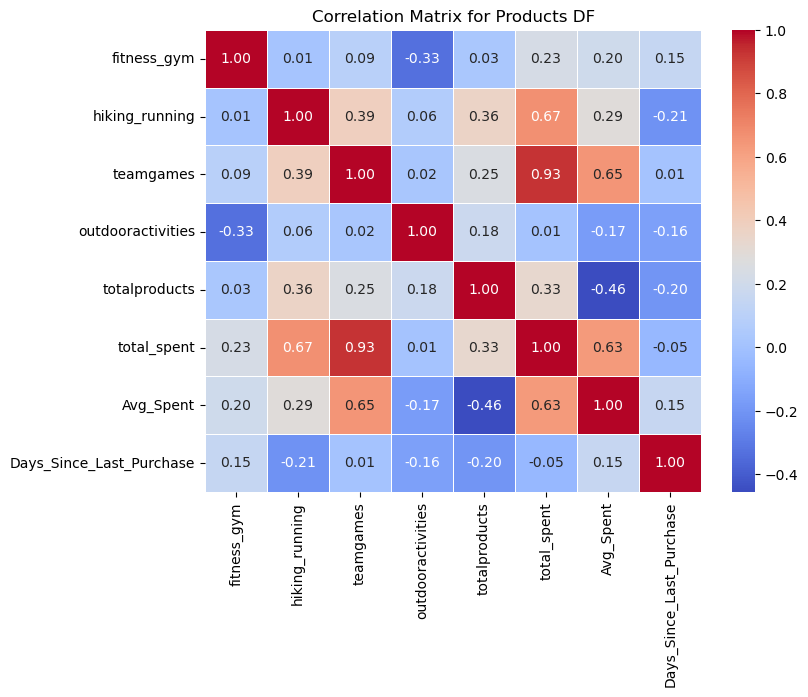

In [54]:
# Calcular a matriz de correlação
correlation_matrix_Products = Products.corr()

plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix_Products, annot=True, cmap='coolwarm', fmt=".2f", linewidths=.5)
plt.title('Correlation Matrix for Products DF')
plt.show() #Vejo correlação mt forte entre Total_Expensed e TeamGames

No high correlations, except 'teamgames' vs 'total_spent', since teamgames influence highly the amount spent due to the high values involved.

## outliers
**Delete outliers and run scaling**
- For each column determine the Q3 + 1.5xQ3 and/or other methods
- then exclude the outliers

**on the original data**

### Q3 + 1.5xIQR technique - removes almost 25% of the data

In [55]:
#get Q3 (75% quantile)
statiscs_table=Products.describe()
statistics_quantiles = statiscs_table.loc[['25%','75%'],:].transpose()
statistics_quantiles

,25%,75%
fitness_gym,25.0,40.0
hiking_running,38.0,66.0
teamgames,121.0,230.0
outdooractivities,32.0,35.0
totalproducts,4.0,6.0
total_spent,227.0,363.0
Avg_Spent,45.0,70.0
Days_Since_Last_Purchase,75.0,99.0


In [56]:
#create interquantile range (Q1-Q3)
statistics_quantiles['IQR'] = statistics_quantiles['75%'] - statistics_quantiles['25%']

In [57]:
#calculate Q3+1.5xIQR
statistics_quantiles['outlier'] = statistics_quantiles['75%'] + statistics_quantiles['IQR']
statistics_quantiles = statistics_quantiles.transpose()
statistics_quantiles

,fitness_gym,hiking_running,teamgames,outdooractivities,totalproducts,total_spent,Avg_Spent,Days_Since_Last_Purchase
25%,25.0,38.0,121.0,32.0,4.0,227.0,45.0,75.0
75%,40.0,66.0,230.0,35.0,6.0,363.0,70.0,99.0
IQR,15.0,28.0,109.0,3.0,2.0,136.0,25.0,24.0
outlier,55.0,94.0,339.0,38.0,8.0,499.0,95.0,123.0


In [58]:
#filter df according to filters above
Products_clean = Products.copy()
for feature in statistics_quantiles.columns:
    Products_clean = Products_clean[Products_clean[feature] < statistics_quantiles.loc['outlier', feature]]

Products_clean.describe()

,fitness_gym,hiking_running,teamgames,outdooractivities,totalproducts,total_spent,Avg_Spent,Days_Since_Last_Purchase
count,3047.000000,3047.000000,3047.000000,3047.000000,3047.000000,3047.000000,3047.000000,3047.000000
mean,29.996390,48.522153,163.469642,33.565146,5.025271,275.553331,56.569413,87.709879
std,11.378854,16.882626,64.594825,1.580289,1.037234,75.492507,15.763134,14.704571
min,0.000000,12.000000,0.000000,28.000000,3.000000,66.000000,14.000000,60.000000
25%,25.000000,36.000000,110.000000,32.000000,4.000000,214.000000,45.000000,76.000000
50%,30.000000,45.000000,162.000000,33.000000,5.000000,273.000000,56.000000,87.000000
75%,37.000000,56.000000,215.000000,35.000000,6.000000,335.000000,68.000000,98.000000
max,54.000000,93.000000,327.000000,37.000000,7.000000,475.000000,94.000000,122.000000


3047 entries remaining.

### 3x Z-scores - 190 datapoints eliminated

In [59]:
Products_cleanzscores = Products.copy()
z_scores = np.abs(stats.zscore(Products))

In [60]:
Products_cleanzscores = Products_cleanzscores[(z_scores < 3).all(axis=1)]
Products_cleanzscores.describe()

,fitness_gym,hiking_running,teamgames,outdooractivities,totalproducts,total_spent,Avg_Spent,Days_Since_Last_Purchase
count,3810.000000,3810.000000,3810.000000,3810.000000,3810.000000,3810.000000,3810.000000,3810.000000
mean,31.675591,52.458530,174.239108,33.596325,5.234908,291.969554,58.218898,87.995276
std,13.826220,21.255277,67.867288,1.644992,1.288595,82.799299,17.785037,16.181774
min,0.000000,9.000000,0.000000,29.000000,2.000000,62.000000,12.000000,59.000000
25%,25.000000,38.000000,119.000000,32.000000,4.000000,225.000000,45.000000,75.000000
50%,31.000000,47.000000,178.000000,34.000000,5.000000,294.000000,57.000000,87.000000
75%,39.000000,62.000000,228.000000,35.000000,6.000000,358.000000,70.000000,99.000000
max,75.000000,152.000000,372.000000,38.000000,9.000000,547.000000,115.000000,139.000000


In [61]:
Products_cleanzscores = Products_cleanzscores.dropna()
print(f'eliminated entries: {4000-len(Products_cleanzscores)}')

eliminated entries: 190


### 99 percentile technique - 299 entries eliminated

In [62]:
#make copy
Products_clean99quantile = Products.copy()
upper_limit = Products_clean99quantile.quantile(0.99)
upper_limit

fitness_gym                  74.00
hiking_running              179.05
teamgames                   309.01
outdooractivities            38.00
totalproducts                10.00
total_spent                 510.03
Avg_Spent                   107.00
Days_Since_Last_Purchase    132.01
Name: 0.99, dtype: float64

In [63]:
#get clean df
Products_clean99quantile = Products_clean99quantile[Products_clean99quantile < upper_limit]
Products_clean99quantile.describe()

,fitness_gym,hiking_running,teamgames,outdooractivities,totalproducts,total_spent,Avg_Spent,Days_Since_Last_Purchase
count,3955.000000,3960.000000,3960.000000,3929.000000,3944.000000,3960.000000,3957.000000,3960.000000
mean,31.483944,53.675253,174.276768,33.514126,5.242394,294.231566,58.036644,87.625758
std,13.601356,23.747463,66.534296,1.589126,1.303176,83.452895,17.893911,16.050213
min,0.000000,9.000000,0.000000,28.000000,2.000000,62.000000,12.000000,59.000000
25%,25.000000,38.000000,120.000000,32.000000,4.000000,227.000000,45.000000,75.000000
50%,31.000000,47.000000,178.000000,33.000000,5.000000,296.500000,57.000000,86.000000
75%,39.000000,64.000000,229.000000,35.000000,6.000000,361.000000,70.000000,99.000000
max,73.000000,179.000000,309.000000,37.000000,9.000000,510.000000,106.000000,132.000000


Different number of entries are eliminated.

array([[<Axes: title={'center': 'fitness_gym'}>,
        <Axes: title={'center': 'hiking_running'}>,
        <Axes: title={'center': 'teamgames'}>],
       [<Axes: title={'center': 'outdooractivities'}>,
        <Axes: title={'center': 'totalproducts'}>,
        <Axes: title={'center': 'total_spent'}>],
       [<Axes: title={'center': 'Avg_Spent'}>,
        <Axes: title={'center': 'Days_Since_Last_Purchase'}>, <Axes: >]],
      dtype=object)

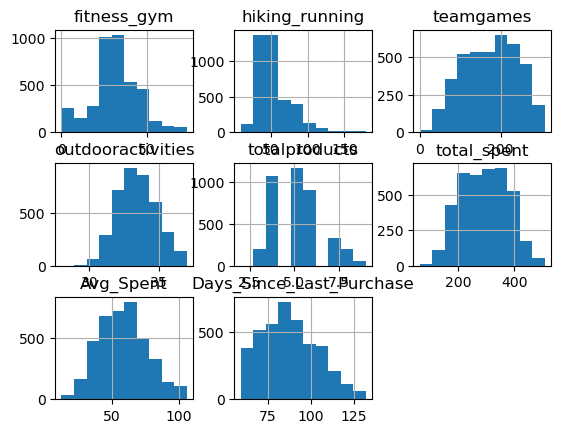

In [64]:
Products_clean99quantile.hist()

- Better distributions 
- but eliminated values even if they were not far away
- created some null values

In [65]:
print('length of df: ', len(Products_clean99quantile))
print('remanining null values:')
Products_clean99quantile.isna().sum()

length of df:  4000
remanining null values:


fitness_gym                 45
hiking_running              40
teamgames                   40
outdooractivities           71
totalproducts               56
total_spent                 40
Avg_Spent                   43
Days_Since_Last_Purchase    40
dtype: int64

Maximum of eliminated entries would be 71.

In [66]:
Products_clean99quantile = Products_clean99quantile.dropna()
print(f'eliminated entries: {4000-len(Products_clean99quantile)}')

eliminated entries: 299


### 99percentile and zscore rule - 132 entries deleted (99percentile & 4xzscore - 64 entries eliminated)

In [67]:
Products_clean99andZscore = Products.copy()

#Calculate Z-scores for each feature
z_scores = np.abs(stats.zscore(Products_clean99andZscore))

# Convert Z-scores into a DataFrame for easier handling
z_scores_df = pd.DataFrame(z_scores, columns=Products_clean99andZscore.columns, index=Products_clean99andZscore.index)

# Create a mask for Z-scores greater than 3
zscore_mask = z_scores_df > 3

# Step 3: Apply both filters
# Create a mask for values above the 99th percentile
upper_limit = Products.quantile(0.99)
quantile_mask = Products > upper_limit

#combined mask
combined_mask = zscore_mask & quantile_mask 


#filter
Products_clean99andZscore = Products[~combined_mask]

Products_clean99andZscore.describe()


,fitness_gym,hiking_running,teamgames,outdooractivities,totalproducts,total_spent,Avg_Spent,Days_Since_Last_Purchase
count,3984.000000,3960.000000,3999.000000,3976.000000,3974.000000,3976.000000,3980.000000,3981.000000
mean,31.793675,53.675253,175.828207,33.567153,5.278309,295.184105,58.338442,87.879176
std,14.026287,23.747463,68.062122,1.652448,1.362009,84.629515,18.277022,16.382357
min,0.000000,9.000000,0.000000,28.000000,2.000000,62.000000,12.000000,59.000000
25%,25.000000,38.000000,121.000000,32.000000,4.000000,227.000000,45.000000,75.000000
50%,31.000000,47.000000,180.000000,33.000000,5.000000,297.000000,57.000000,86.000000
75%,39.000000,64.000000,229.500000,35.000000,6.000000,362.000000,70.000000,99.000000
max,75.000000,179.000000,384.000000,38.000000,10.000000,567.000000,115.000000,139.000000


In [68]:
Products_clean99andZscore.info()

<class 'pandas.core.frame.DataFrame'>
Index: 4000 entries, 4 to 6496
Data columns (total 8 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   fitness_gym               3984 non-null   float64
 1   hiking_running            3960 non-null   float64
 2   teamgames                 3999 non-null   float64
 3   outdooractivities         3976 non-null   float64
 4   totalproducts             3974 non-null   float64
 5   total_spent               3976 non-null   float64
 6   Avg_Spent                 3980 non-null   float64
 7   Days_Since_Last_Purchase  3981 non-null   float64
dtypes: float64(8)
memory usage: 410.3 KB


In [69]:
Products_clean99andZscore.isna().sum()

fitness_gym                 16
hiking_running              40
teamgames                    1
outdooractivities           24
totalproducts               26
total_spent                 24
Avg_Spent                   20
Days_Since_Last_Purchase    19
dtype: int64

Deletes between 1 and 40 entries which is an aceptable number (may be more when combined)

In [70]:
Products_clean99andZscore = Products_clean99andZscore.dropna()
Products_clean99andZscore.info()

<class 'pandas.core.frame.DataFrame'>
Index: 3868 entries, 4 to 6496
Data columns (total 8 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   fitness_gym               3868 non-null   float64
 1   hiking_running            3868 non-null   float64
 2   teamgames                 3868 non-null   float64
 3   outdooractivities         3868 non-null   float64
 4   totalproducts             3868 non-null   float64
 5   total_spent               3868 non-null   float64
 6   Avg_Spent                 3868 non-null   float64
 7   Days_Since_Last_Purchase  3868 non-null   float64
dtypes: float64(8)
memory usage: 272.0 KB


In [71]:
print(f'% of deleted entries: {(4000-len(Products_clean99andZscore))/4000*100:.1f}')
print(f'deleted entries: {4000-len(Products_clean99andZscore)}')

% of deleted entries: 3.3
deleted entries: 132


### 4x ZScores - eliminated 64 entries

In [72]:
Products_cleanzscoresextra = Products.copy()
z_scores = np.abs(stats.zscore(Products_cleanzscoresextra))

In [73]:
Products_cleanzscoresextra = Products_cleanzscoresextra[(z_scores < 4).all(axis=1)]
Products_cleanzscoresextra.describe()

,fitness_gym,hiking_running,teamgames,outdooractivities,totalproducts,total_spent,Avg_Spent,Days_Since_Last_Purchase
count,3936.000000,3936.000000,3936.000000,3936.000000,3936.000000,3936.000000,3936.000000,3936.000000
mean,31.845528,53.717988,175.089431,33.611280,5.283537,294.264228,58.451220,88.104675
std,14.148586,23.977642,67.906548,1.695593,1.380530,84.023496,18.489453,16.587643
min,0.000000,9.000000,0.000000,28.000000,2.000000,62.000000,12.000000,59.000000
25%,25.000000,38.000000,120.000000,32.000000,4.000000,226.000000,45.000000,75.000000
50%,31.000000,47.000000,178.000000,33.500000,5.000000,296.000000,57.000000,87.000000
75%,39.000000,64.000000,229.000000,35.000000,6.000000,361.000000,70.000000,99.000000
max,86.000000,186.000000,372.000000,40.000000,11.000000,573.000000,133.000000,156.000000


In [74]:
Products_cleanzscoresextra = Products_cleanzscoresextra.dropna()
print(f'eliminated entries: {4000-len(Products_cleanzscoresextra)}')

eliminated entries: 64


### clean df

In [75]:
Products_clean = Products_cleanzscoresextra
Products_clean.head()

,fitness_gym,hiking_running,teamgames,outdooractivities,totalproducts,total_spent,Avg_Spent,Days_Since_Last_Purchase
Cust_ID,,,,,,,,
4,0,76,248,37,6,361,61,69
5,0,75,248,37,6,360,60,71
6,6,69,215,34,5,324,65,73
9,36,71,248,35,8,390,49,75
10,8,97,204,34,5,343,69,73


## Transform

#scaling
scaler = StandardScaler()
Products_scaled = pd.DataFrame(scaler.fit_transform(Products_clean), columns = Products.columns) #applied to all columns because all are numeric
Products_scaled = Products_scaled.drop('total_spent', axis=1) #because of high correlation to teamgames
Products_scaled.head()

#check data variability
sns.boxplot(data=Products_scaled)
plt.xticks(rotation=90)
plt.show() 

In [76]:
#get IDs
ids = Products_clean.index

array([[<Axes: title={'center': 'fitness_gym'}>,
        <Axes: title={'center': 'hiking_running'}>,
        <Axes: title={'center': 'teamgames'}>],
       [<Axes: title={'center': 'outdooractivities'}>,
        <Axes: title={'center': 'totalproducts'}>,
        <Axes: title={'center': 'total_spent'}>],
       [<Axes: title={'center': 'Avg_Spent'}>,
        <Axes: title={'center': 'Days_Since_Last_Purchase'}>, <Axes: >]],
      dtype=object)

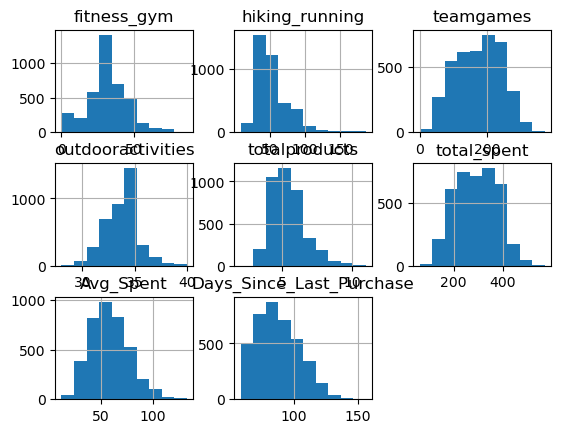

In [77]:
Products_clean.hist()

In [78]:
#skewness
print('original skewness')
display(Products.skew())
print()
print()
print('cleaned skewness')
Products_clean.skew()

original skewness


fitness_gym                 0.346342
hiking_running              4.671687
teamgames                   0.740859
outdooractivities           0.414896
totalproducts               1.791119
total_spent                 0.829234
Avg_Spent                   0.559660
Days_Since_Last_Purchase    0.715300
dtype: float64



cleaned skewness


fitness_gym                 0.185997
hiking_running              1.746290
teamgames                  -0.045738
outdooractivities           0.354366
totalproducts               0.848180
total_spent                 0.073696
Avg_Spent                   0.457438
Days_Since_Last_Purchase    0.510210
dtype: float64

**Great improvement in skewness.** 

**Transform all with skewness above 0.5.**


### Hiking_running

In [79]:
# Applying Transformations to hiking_running
hiking_running_log = np.log(Products_clean.hiking_running)
hiking_running_sqrt = np.sqrt(Products_clean.hiking_running)
hiking_running_cbrt = np.cbrt(Products_clean.hiking_running)

print(f'Skewness of original data: {Products_clean.hiking_running.skew():.5f}')
print(f'Skewness after Log Transformation: {hiking_running_log.skew():.5f}')
print(f'Skewness after Square Root Transformation: {hiking_running_sqrt.skew():.5f}')
print(f'Skewness after Cubic Root Transformation: {hiking_running_cbrt.skew():.5f}')

Skewness of original data: 1.74629
Skewness after Log Transformation: 0.36105
Skewness after Square Root Transformation: 1.01750
Skewness after Cubic Root Transformation: 0.79611


In [80]:
# Applying Box-Cox Transformation after checking all values are positive
if (Products_clean.hiking_running > 0).all(): #needs all values to be positive
    hiking_running_boxcox, _ = boxcox(Products_clean.hiking_running)
    hiking_running_boxcox = pd.Series(hiking_running_boxcox)
else:
    # Consider alternative transformations or handling strategies
    print("Not all SalePrice values are positive. Consider using Yeo-Johnson or handling negative values.")
print(f"Skewness after Box-Cox Transformation: {hiking_running_boxcox.skew():.5f}")

Skewness after Box-Cox Transformation: -0.01312


<Axes: >

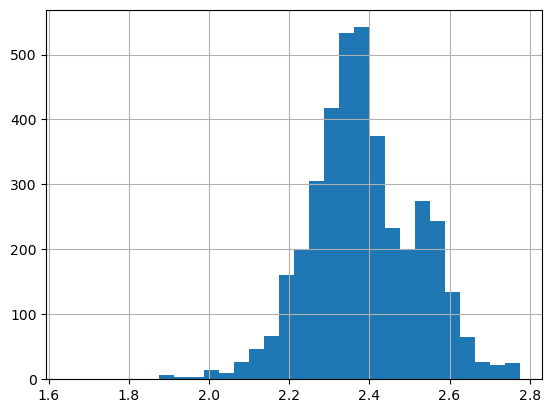

In [81]:
#check box cox transform
hiking_running_boxcox.hist(bins=30)

<Axes: >

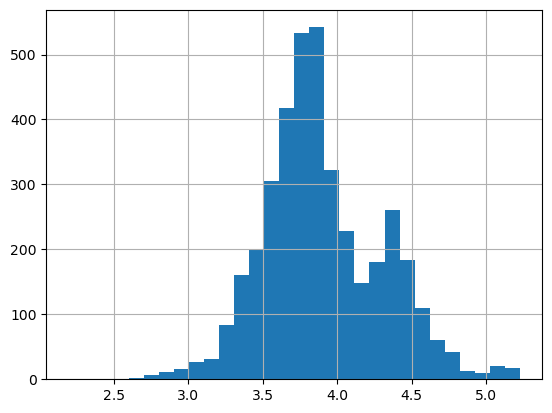

In [82]:
#check log transform
hiking_running_log.hist(bins=30)

Similar. Box Cox transform is better: lower skewness value.
However Box Cox insert empty values to df, so we will use Log method.

In [83]:
#apply to original dataset
Products_trans = Products_clean.copy()
Products_trans.hiking_running = hiking_running_log

### totalproducts

In [84]:
# Applying Transformations to hiking_running
totalproducts_log = np.log(Products_clean.totalproducts)
totalproducts_sqrt = np.sqrt(Products_clean.totalproducts)
totalproducts_cbrt = np.cbrt(Products_clean.totalproducts)

print(f'Skewness of original data: {Products_clean.totalproducts.skew():.5f}')
print(f'Skewness after Log Transformation: {totalproducts_log.skew():.5f}')
print(f'Skewness after Square Root Transformation: {totalproducts_sqrt.skew():.5f}')
print(f'Skewness after Cubic Root Transformation: {totalproducts_cbrt.skew():.5f}')

Skewness of original data: 0.84818
Skewness after Log Transformation: 0.09908
Skewness after Square Root Transformation: 0.46847
Skewness after Cubic Root Transformation: 0.34485


De novo, Log apresenta boa transformação levando a um skewness reduzido.

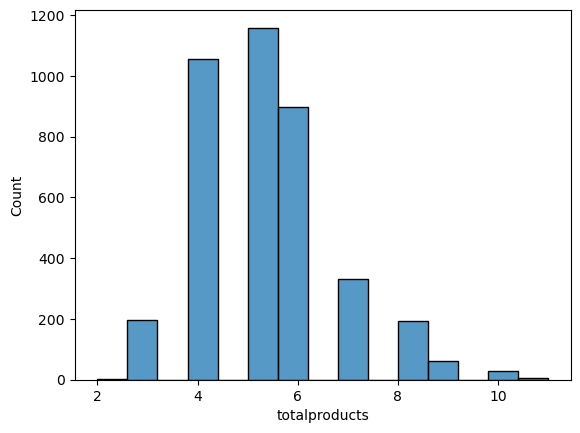

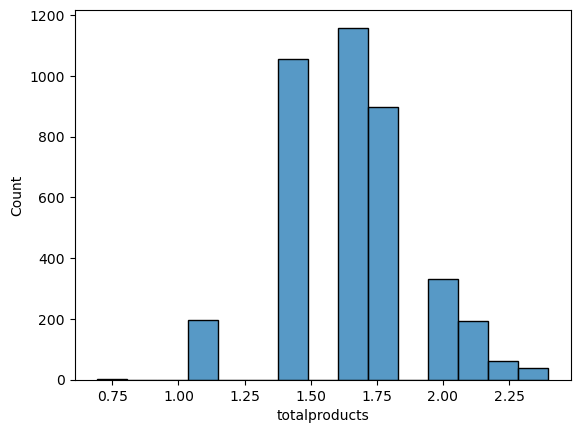

In [85]:
sns.histplot(Products_clean.totalproducts, bins=15)
plt.show()
sns.histplot(totalproducts_log, bins=15)
plt.show()

In [86]:
#transform df
Products_trans.totalproducts = totalproducts_log

## Scaling on transformed data

In [87]:
#run scaling
scaler = StandardScaler()
Products_trans_scaled = pd.DataFrame(scaler.fit_transform(Products_trans), columns = Products_trans.columns) #applied to all columns because all are numeric
Products_trans_scaled = Products_trans_scaled.drop('total_spent', axis=1) #because of high correlation to teamgames
Products_trans_scaled.index = Products_trans.index
Products_trans_scaled.head()

,fitness_gym,hiking_running,teamgames,outdooractivities,totalproducts,Avg_Spent,Days_Since_Last_Purchase
Cust_ID,,,,,,,
4,-2.251078,1.082187,1.073826,1.998800,0.628263,0.137868,-1.151888
5,-2.251078,1.048844,1.073826,1.998800,0.628263,0.083776,-1.031301
6,-1.826954,0.838944,0.587803,0.229282,-0.088779,0.354235,-0.910714
9,0.293669,0.910873,1.073826,0.819121,1.759670,-0.511233,-0.790127
10,-1.685579,1.696361,0.425795,0.229282,-0.088779,0.570602,-0.910714


In [88]:
Products_trans_scaled.info()

<class 'pandas.core.frame.DataFrame'>
Index: 3936 entries, 4 to 6496
Data columns (total 7 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   fitness_gym               3936 non-null   float64
 1   hiking_running            3936 non-null   float64
 2   teamgames                 3936 non-null   float64
 3   outdooractivities         3936 non-null   float64
 4   totalproducts             3936 non-null   float64
 5   Avg_Spent                 3936 non-null   float64
 6   Days_Since_Last_Purchase  3936 non-null   float64
dtypes: float64(7)
memory usage: 246.0 KB


## Modelling - kmeans clustering

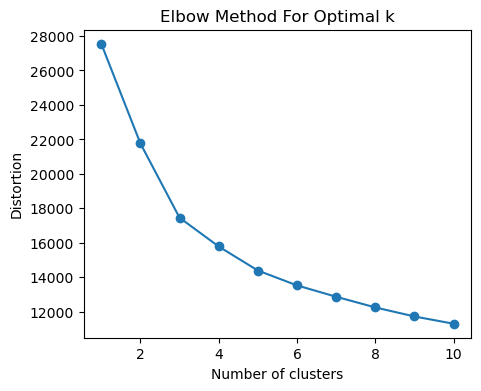

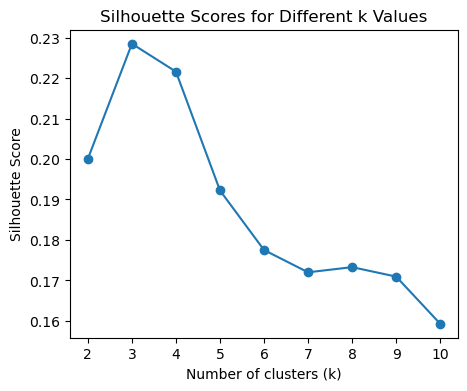

In [89]:
# Calculate distortion for a range of number of cluster
distortions = [] #for elbow method

#for silhouette method
features = Products_trans_scaled
silhouette_scores = []

#calculate relevant measurements for both elbow and silhouette methods
for i in range(1, 11):
    km = KMeans(n_clusters=i, init='k-means++', n_init=10, max_iter=300, random_state=42) #kmean++ to get a better spreading of the initial centroids
    cluster_labels = km.fit_predict(features)  # Fit and predict simultaneously
    #calculate inertia score
    distortions.append(km.inertia_)

    # Calculate silhouette scores
    if i > 1:
        silhouette_avg = silhouette_score(features, cluster_labels)
        silhouette_scores.append(silhouette_avg)

# Plot the elbow graph
plt.figure(figsize=(5, 4))
plt.plot(range(1, 11), distortions, marker='o')
plt.title('Elbow Method For Optimal k')
plt.xlabel('Number of clusters')
plt.ylabel('Distortion')
plt.show()

# Plot the silhouette scores, note the range adjustment for x-axis
if len(silhouette_scores) > 0:  # Check if list is not empty
    plt.figure(figsize=(5, 4))
    plt.plot(range(2, 11), silhouette_scores, marker='o')
    plt.title('Silhouette Scores for Different k Values')
    plt.xlabel('Number of clusters (k)')
    plt.ylabel('Silhouette Score')
    plt.show()

### Conclusion on clusters
- elbow method not clear on the best number of cluster with a smooth curve
- silhuette method suggests 3 clusters, followed by 4, then by 2.

We will get **3** clusters first. Depending on difficulties in interpreting the data, we may go to 2.

In [90]:
#save model and assign clusters
n_clusters=3
km = KMeans(n_clusters=n_clusters, init='k-means++', n_init=10, max_iter=300, random_state=42)
km.fit(Products_trans_scaled) #create model
clusters = km.labels_ #assign clusters

## Assigning labels to datasets

In [91]:
#Products transformed e scaled
Products_trans_scaled['cluster_label']=clusters

Products_trans_scaled.head()

,fitness_gym,hiking_running,teamgames,outdooractivities,totalproducts,Avg_Spent,Days_Since_Last_Purchase,cluster_label
Cust_ID,,,,,,,,
4,-2.251078,1.082187,1.073826,1.998800,0.628263,0.137868,-1.151888,0
5,-2.251078,1.048844,1.073826,1.998800,0.628263,0.083776,-1.031301,0
6,-1.826954,0.838944,0.587803,0.229282,-0.088779,0.354235,-0.910714,0
9,0.293669,0.910873,1.073826,0.819121,1.759670,-0.511233,-0.790127,0
10,-1.685579,1.696361,0.425795,0.229282,-0.088779,0.570602,-0.910714,0


In [92]:
#Products original (menos outliers)
Products_final = Products.loc[Products_trans_scaled.index]
Products_final['cluster_label']= clusters #assign clusters to df
Products_final.drop('total_spent', axis=1, inplace=True)
Products_final.head()

,fitness_gym,hiking_running,teamgames,outdooractivities,totalproducts,Avg_Spent,Days_Since_Last_Purchase,cluster_label
Cust_ID,,,,,,,,
4,0,76,248,37,6,61,69,0
5,0,75,248,37,6,60,71,0
6,6,69,215,34,5,65,73,0
9,36,71,248,35,8,49,75,0
10,8,97,204,34,5,69,73,0


In [93]:
Products_final.info()

<class 'pandas.core.frame.DataFrame'>
Index: 3936 entries, 4 to 6496
Data columns (total 8 columns):
 #   Column                    Non-Null Count  Dtype
---  ------                    --------------  -----
 0   fitness_gym               3936 non-null   int64
 1   hiking_running            3936 non-null   int64
 2   teamgames                 3936 non-null   int64
 3   outdooractivities         3936 non-null   int64
 4   totalproducts             3936 non-null   int64
 5   Avg_Spent                 3936 non-null   int32
 6   Days_Since_Last_Purchase  3936 non-null   int64
 7   cluster_label             3936 non-null   int32
dtypes: int32(2), int64(6)
memory usage: 246.0 KB


## Export DFs

In [94]:
#export final df with original cleaned data and a column with clusters
Products_final.to_csv('exported_data/Product_clustered.csv', index=True) #includes indices

#then import with:
#pd.read_csv('exported_data/Product_clustered.csv', index_col=0)

## Clusters analysis

In [95]:
#count entries in each cluster
print(Products_final.groupby('cluster_label').cluster_label.count().transpose())

print((Products_final.groupby('cluster_label').cluster_label.count().transpose() / len(Products_final)*100))

cluster_label
0    1114
1    1230
2    1592
Name: cluster_label, dtype: int64
cluster_label
0    28.302846
1    31.250000
2    40.447154
Name: cluster_label, dtype: float64


In [96]:
#look at means
Products_final.groupby('cluster_label').mean().transpose()

cluster_label,0,1,2
fitness_gym,26.268402,37.223577,31.592965
hiking_running,77.332136,52.682114,37.994347
teamgames,218.937163,217.892683,111.336683
outdooractivities,34.793537,32.767480,33.435930
totalproducts,6.358169,4.548780,5.099246
Avg_Spent,58.156194,77.024390,44.307789
Days_Since_Last_Purchase,75.517953,99.570732,88.053392


Análise dos 3 clusters em curso  

1114, 1230, 1592 – boa divisão  


in order:
fitness_gym:..............1 2 0  
hiking_running:...........0 1 2  
teamgames:................0+1 2  
outdooractivities:........  =  
totalproducts:............  
Avg_spent:................1 0 2  
Days_Since_Last_Purchase: 1 2 0  

cluster 0:
- buyer of hiking_running and teamgames
- medium spent money and medium buying frequency

cluster 1:
- buys more expensive products
- fitness & gym best buyer
- takes longer to return to store

cluster 2
- goes more frequently
- buys cheaper items

### Team Games spending

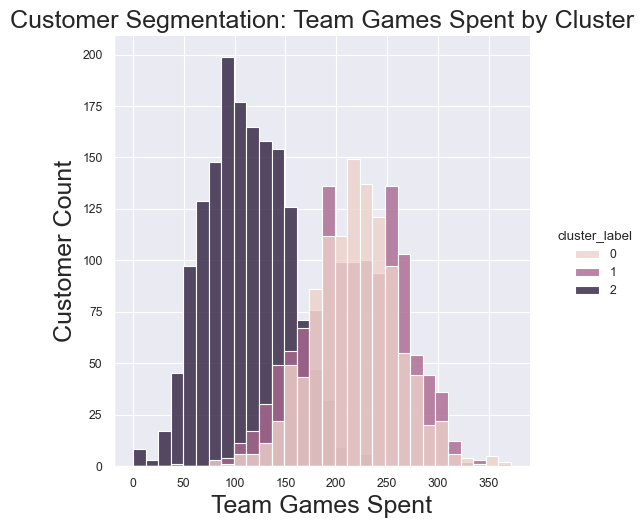

In [97]:
#plot team spent per cluster
sns.set_style("darkgrid")
sns.set_context("paper")

sns.displot(Products_final, x=Products_final.teamgames,
            hue=Products_final.cluster_label, alpha=0.8,bins=30)

plt.xlabel('Team Games Spent', fontsize=18)
plt.ylabel('Customer Count', fontsize=18)
plt.title('Customer Segmentation: Team Games Spent by Cluster', fontsize=18)

plt.show()

### nr of Costumers

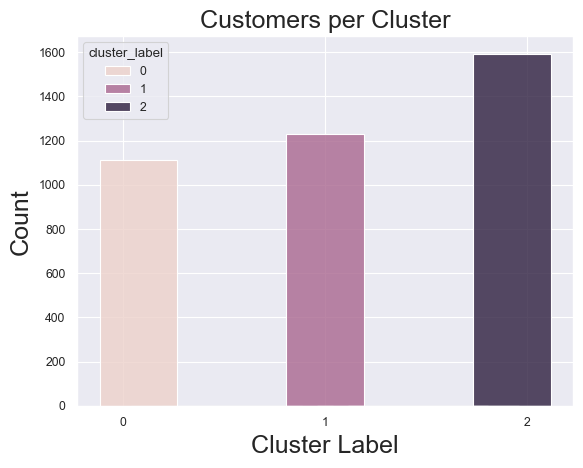

In [98]:
#plot customers per cluster
sns.set_style("darkgrid")
sns.set_context("paper")

sns.histplot(data=Products_final, hue=Products_final.cluster_label,
             x="cluster_label", element='bars', shrink=2.5, alpha=0.8)

plt.xticks([0,1,2])
plt.xlabel('Cluster Label', fontsize=18)
plt.ylabel('Count', fontsize=18)
plt.title('Customers per Cluster', fontsize=18)

plt.show()

### Days_Since_Last_Purchase

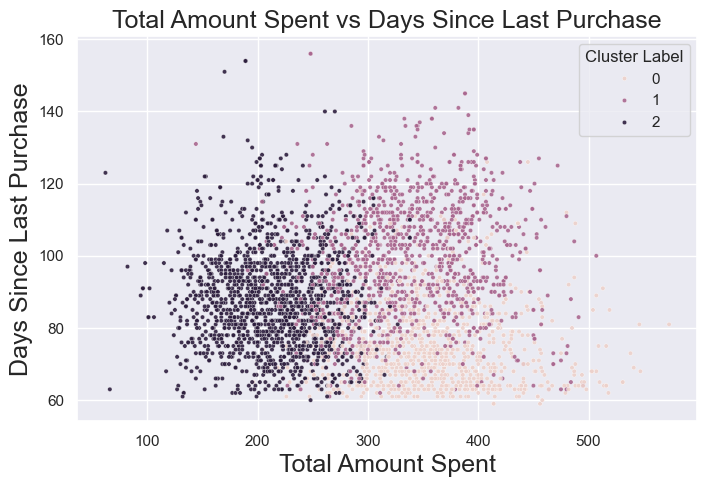

In [99]:
#plot scatterplot total spent vs days since last purchase

#add total spent column just for visualization purposes
Products_final["total_spent"] = Products_final[["fitness_gym",
                                                "hiking_running","teamgames",
                                                "outdooractivities"]].sum(axis=1)

#filter in case need to visualize only part of the clusters
filtered_data = Products_final[Products_final['cluster_label'].isin([0,1,2])]

sns.set_style("darkgrid")
sns.set_context("notebook")

plt.figure(figsize=(8, 5))

sns.scatterplot(x=Products_final['total_spent'],
                y=Products_final['Days_Since_Last_Purchase'],
                hue=filtered_data['cluster_label'],
                alpha=0.9, s=10)

plt.xlabel('Total Amount Spent', fontsize=18 )
plt.ylabel('Days Since Last Purchase', fontsize=18)
plt.title('Total Amount Spent vs Days Since Last Purchase', fontsize=18)
plt.legend(title='Cluster Label')
plt.show()

# drop total spent,created just for visualization purposes
Products_final.drop('total_spent', axis=1, inplace=True)

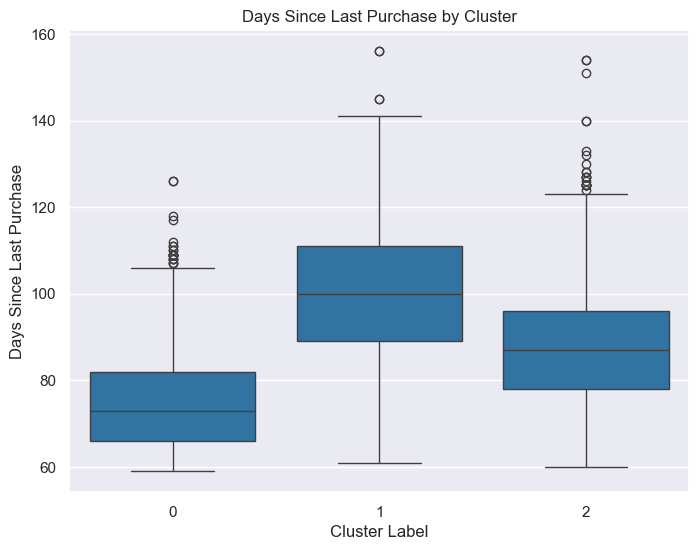

In [100]:
#Products.query("cluster_label == 0")['Days_Since_Last_Purchase'].plot())

# Filtering data for cluster_label == 0
data = Products_final[Products_final['cluster_label'].isin([0, 1, 2])]

# Create a boxplot
plt.figure(figsize=(8, 6))
sns.boxplot(data=data, x='cluster_label', y='Days_Since_Last_Purchase')
plt.title('Days Since Last Purchase by Cluster')
plt.xlabel('Cluster Label')
plt.ylabel('Days Since Last Purchase')
plt.show()


### Statistics

In [101]:
#statistics
feature = 'Days_Since_Last_Purchase'
# Extracting data for each cluster
cluster_0_data = Products_final.query("cluster_label == 0")[feature]
cluster_1_data = Products_final.query("cluster_label == 1")[feature]

# Performing the t-test
t_stat, p_value = ttest_ind(cluster_0_data, cluster_1_data, equal_var=False)

# Printing the results
print("T-statistic:", t_stat)
print("P-value:", p_value)

T-statistic: -42.77132805866067
P-value: 1.7052759436493478e-292


**They are statistically significant**

### fitness_gym

In [102]:
#statistics
feature = 'fitness_gym'
# Extracting data for each cluster
cluster_0_data = Products_final.query("cluster_label == 0")[feature]
cluster_2_data = Products_final.query("cluster_label == 2")[feature]

# Performing the t-test
t_stat, p_value = ttest_ind(cluster_0_data, cluster_2_data, equal_var=False)

# Printing the results
print("T-statistic:", t_stat)
print("P-value:", p_value)

T-statistic: -9.271075797481245
P-value: 5.787250766446733e-20


**fitness_gym is statistically different**

### hiking_running

In [103]:
#statistics
feature = 'hiking_running'
# Extracting data for each cluster
cluster_0_data = Products_final.query("cluster_label == 0")[feature]
cluster_2_data = Products_final.query("cluster_label == 2")[feature]

# Performing the t-test
t_stat, p_value = ttest_ind(cluster_0_data, cluster_2_data, equal_var=False)

# Printing the results
print("T-statistic:", t_stat)
print("P-value:", p_value)

T-statistic: 55.52449465698657
P-value: 0.0


**hiking_running is statistically different**

## PCA visualization

In [104]:
Products_trans_scaled.head()

,fitness_gym,hiking_running,teamgames,outdooractivities,totalproducts,Avg_Spent,Days_Since_Last_Purchase,cluster_label
Cust_ID,,,,,,,,
4,-2.251078,1.082187,1.073826,1.998800,0.628263,0.137868,-1.151888,0
5,-2.251078,1.048844,1.073826,1.998800,0.628263,0.083776,-1.031301,0
6,-1.826954,0.838944,0.587803,0.229282,-0.088779,0.354235,-0.910714,0
9,0.293669,0.910873,1.073826,0.819121,1.759670,-0.511233,-0.790127,0
10,-1.685579,1.696361,0.425795,0.229282,-0.088779,0.570602,-0.910714,0


In [105]:
#get features
Products_trans_scaled_noclusters = Products_trans_scaled.drop('cluster_label', axis=1)
nr_features = Products_trans_scaled_noclusters.shape[1]
pca = PCA(n_components=nr_features)
Products_pca= pd.DataFrame(pca.fit_transform(Products_trans_scaled_noclusters))
Products_pca.head()

,0,1,2,3,4,5,6
0,-1.408423,2.682074,-1.902591,0.273236,-0.108514,-0.491424,-0.048903
1,-1.354927,2.647977,-1.878847,0.382541,-0.137509,-0.481043,-0.081986
2,-0.937268,1.104598,-1.489800,-0.536064,-0.875171,-0.172192,-0.037176
3,-1.236771,1.946345,1.092355,0.147159,0.267376,-0.325199,-0.109963
4,-1.429877,1.189813,-1.465674,-0.681434,-0.846840,0.569179,0.041164


In [106]:
#recover index values
Products_pca.index = Products_trans_scaled.index
Products_pca.head()

,0,1,2,3,4,5,6
Cust_ID,,,,,,,
4,-1.408423,2.682074,-1.902591,0.273236,-0.108514,-0.491424,-0.048903
5,-1.354927,2.647977,-1.878847,0.382541,-0.137509,-0.481043,-0.081986
6,-0.937268,1.104598,-1.489800,-0.536064,-0.875171,-0.172192,-0.037176
9,-1.236771,1.946345,1.092355,0.147159,0.267376,-0.325199,-0.109963
10,-1.429877,1.189813,-1.465674,-0.681434,-0.846840,0.569179,0.041164


In [107]:
# Print the results
print('PCA Summary')
print('No. of features: ', Products_pca.shape[1])
print('No. of samples: ', Products_pca.shape[0])
print('No. of components: ', pca.n_components_)
print('Explained variance ratio: ', pca.explained_variance_ratio_)

PCA Summary
No. of features:  7
No. of samples:  3936
No. of components:  7
Explained variance ratio:  [0.29584245 0.27445803 0.16030744 0.12490417 0.08717623 0.05419417
 0.0031175 ]


In [108]:
#plot cumulative explained variance
cum_variance=[]
for i, value in enumerate(pca.explained_variance_ratio_):
    if i==0:
        cum_variance.append(value)
    else:
        cum_variance.append(value+cum_variance[i-1])
print('Cumulative variance ratio over PCs: ', cum_variance)

Cumulative variance ratio over PCs:  [0.2958424532618348, 0.5703004785895556, 0.7306079147587692, 0.8555120885427875, 0.9426883228948733, 0.9968824971660045, 1.0000000000000002]


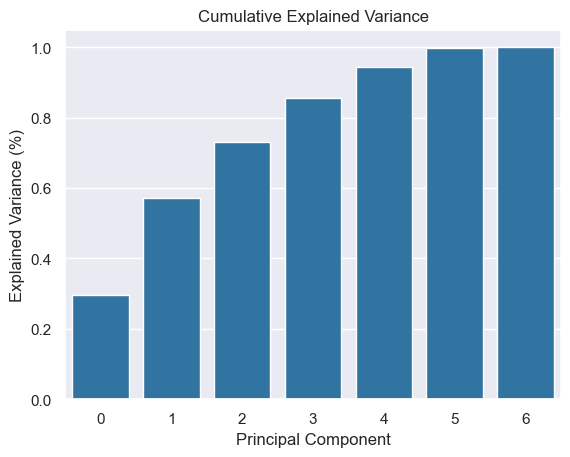

In [109]:
#Graphical representation of PCs' cumulative variance ratio
sns.barplot(data=cum_variance)
plt.title('Cumulative Explained Variance')
plt.xlabel('Principal Component')
plt.ylabel('Explained Variance (%)')
plt.show()

In [110]:
print(f'the cumulative explained variance of the first 2 PCs is: {cum_variance[1]:.2f}')

the cumulative explained variance of the first 2 PCs is: 0.57


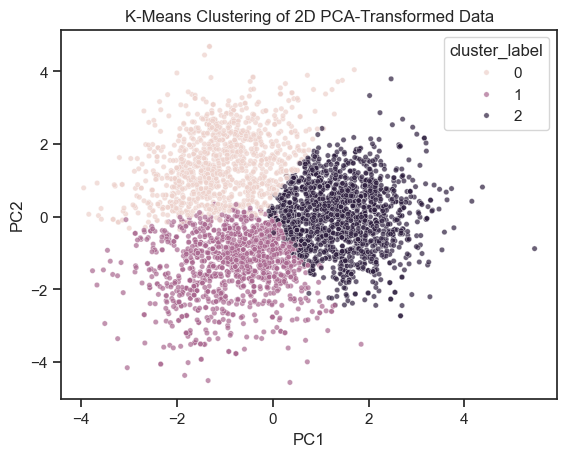

In [111]:
#look at clusters in 2D, with clustering with 2 components

sns.set_style("ticks")
sns.set_context("notebook")
sns.scatterplot(data=Products_pca, x=Products_pca[0], y=Products_pca[1],
                hue=Products_trans_scaled['cluster_label'], alpha=0.7, s=15)
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.title('K-Means Clustering of 2D PCA-Transformed Data')
plt.show()

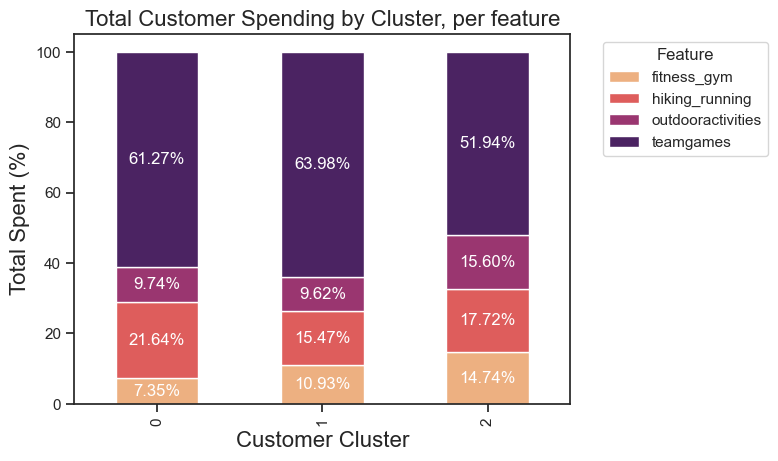

In [112]:
#stacked bar plot to see % of total spending per feature, per cluster
stacked_df = Products_final.pivot_table(index='cluster_label', values=["fitness_gym",
                                                "hiking_running","teamgames",
                                                "outdooractivities"], aggfunc='sum')
total_spent = stacked_df.sum(axis=1)
 
# normalize the values to get the percentage of total spent
stacked_df_normalized = stacked_df.div(total_spent, axis=0) * 100
 
ax = stacked_df_normalized.plot(kind='bar', stacked=True, colormap='flare')
 
# customize the plot
plt.xlabel('Customer Cluster', fontsize=16)
plt.ylabel('Total Spent (%)', fontsize=16)
plt.title('Total Customer Spending by Cluster, per feature', fontsize=16)
plt.legend(title='Feature', bbox_to_anchor=(1.05, 1), loc='upper left')
 
# annotate the percentages inside each stacked portion
for p in ax.patches:
    width, height = p.get_width(), p.get_height()
    x, y = p.get_x(), p.get_y()
    ax.annotate(f'{height:.2f}%', (x + width / 2, y + height / 2), ha='center', va='center', color='white')
 
plt.show()

# Demographic Dataset

In [113]:
plt.rcParams['figure.figsize'] = [6, 4]

In [114]:
Demographic=pd.read_csv("data/Demographic.txt", sep='\t')
Demographic.set_index("Cust_ID", inplace=True)
Demographic

,name,birth_year,education_level,dependents,City
Cust_ID,,,,,
4,Mr Daniel Spencer,2002,Master,1,NaN
5,Miss Abigail Garcia,1994,high school,0,Birmingham
6,Miss Laura Williams,2005,PhD,1,NaN
9,Mr Justin Hamilton,2003,high school,0,NaN
10,Mr Steven Vaughn,2002,less than high school,0,NaN
...,...,...,...,...,...
6489,Miss Jamie Young,1995,Bachelor,0,NaN
6491,Mr Cody Turner,1996,Master,0,NaN
6492,Mr Paul Ingram,2004,high school,0,Birmingham


In [115]:
#check duplicates
len(Demographic[Demographic.duplicated()])

0

In [116]:
Demographic.info()

<class 'pandas.core.frame.DataFrame'>
Index: 4000 entries, 4 to 6496
Data columns (total 5 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   name             4000 non-null   object
 1   birth_year       4000 non-null   int64 
 2   education_level  4000 non-null   object
 3   dependents       4000 non-null   int64 
 4   City             2019 non-null   object
dtypes: int64(2), object(3)
memory usage: 187.5+ KB


Types seem ok.  
Only City has missing values.

In [117]:
#missing values number
#print('Missing values in City are: ', Demographic['City'].isna().sum())
#print(f'representing {Demographic['City'].isna().sum()/len(Demographic)*100:.1f}% of the dataset')

That is a lot. But deleting the column may not be the best option as the cities informed may be interesting info.

In [118]:
Demographic.describe()

,birth_year,dependents
count,4000.000000,4000.000000
mean,1989.299000,0.298000
std,16.398836,0.498757
min,1944.000000,0.000000
25%,1980.000000,0.000000
50%,1997.000000,0.000000
75%,2002.000000,1.000000
max,2006.000000,2.000000


Most clients do not have children.  

Average birth year is 1989, median is 1997, indicating a skewness in the data to older clients.

In [119]:
Demographic.describe(include='O')

,name,education_level,City
count,4000,4000,2019
unique,3892,7,3
top,Mr Michael Jackson,high school,Birmingham
freq,4,1280,1284


Many unique names, which will not add relevant info.  

7 different levels of education, high the most common.

Apparently 3 different cities.

### Birth year to age

Age is a more useful info that birht year. Let's change it.

In [120]:
#create age column and delete birth_year
Demographic['age'] = 2024 - Demographic['birth_year']
Demographic = Demographic.drop(['birth_year'], axis=1)
Demographic.info()

<class 'pandas.core.frame.DataFrame'>
Index: 4000 entries, 4 to 6496
Data columns (total 5 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   name             4000 non-null   object
 1   education_level  4000 non-null   object
 2   dependents       4000 non-null   int64 
 3   City             2019 non-null   object
 4   age              4000 non-null   int64 
dtypes: int64(2), object(3)
memory usage: 187.5+ KB


In [121]:
#skewness
Demographic['age'].skew()

1.058954622196828

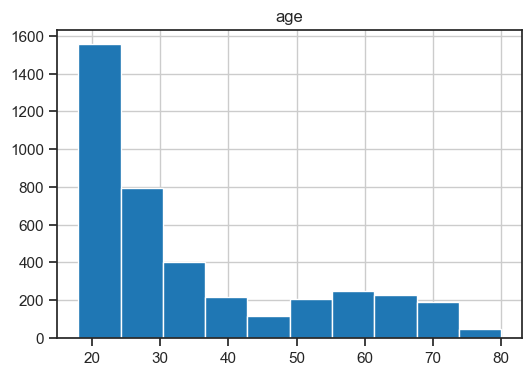

In [122]:
Demographic['age'].hist()
plt.title('age')
plt.show()

Clear right tail.  

No apparent outliers.

### City

In [123]:
Demographic['City'].unique()

array([nan, 'Birmingham', 'Brimingham', 'London'], dtype=object)

In [124]:
Demographic['City']=Demographic['City'].replace('Brimingham', 'Birmingham')
Demographic['City'].value_counts()

City
Birmingham    1319
London         700
Name: count, dtype: int64

Only two cities.   
Let's deal with the missing cities.  

Since we have no information about them, we will create the valu 'other' for the missing values.

In [125]:
#fill NA as 'other'
Demographic['City'] = Demographic['City'].fillna('other')
Demographic['City'].value_counts()

City
other         1981
Birmingham    1319
London         700
Name: count, dtype: int64

In [126]:
#change to snake_case
Demographic = Demographic.rename(columns={'City': 'city'})
Demographic.info()

<class 'pandas.core.frame.DataFrame'>
Index: 4000 entries, 4 to 6496
Data columns (total 5 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   name             4000 non-null   object
 1   education_level  4000 non-null   object
 2   dependents       4000 non-null   int64 
 3   city             4000 non-null   object
 4   age              4000 non-null   int64 
dtypes: int64(2), object(3)
memory usage: 187.5+ KB


### Dependents

In [127]:
Demographic['dependents'].value_counts()

dependents
0    2887
1    1034
2      79
Name: count, dtype: int64

There is value 2, although there should be only value 1 and 0.  
We will assume that someone entered the number of children in the system, so we will replace 2 by 1 to indicate True for children.

In [128]:
Demographic.loc[Demographic['dependents'] == 2, 'dependents'] = 1
Demographic['dependents'].value_counts()

dependents
0    2887
1    1113
Name: count, dtype: int64

In [129]:
#print(f'{Demographic['dependents'].mean()*100:.1f}% of customers have dependents')

### Gender based on name

In [130]:
# Function to determine gender based on name (Mr and Mrs)
def determinar_sexo(name):
    if name.startswith('Mr'):
        return 'male'
    else:
        return 'female'


In [131]:
#create column sex
Demographic['sex'] = Demographic['name'].apply(determinar_sexo)
Demographic['sex'].value_counts()

sex
female    2368
male      1632
Name: count, dtype: int64

In [132]:
#check total created columns
Demographic['sex'].isna().sum()

0

All customers successfully assigned a gender.

In [133]:
#delete 'name' column
Demographic = Demographic.drop(['name'], axis=1)

### Education

In [134]:
Demographic['education_level'].unique()

array(['Master', 'high school', 'PhD', 'less than high school',
       'Bachelor', 'High School', 'PHD'], dtype=object)

Some mistakes like 'PHD' and 'PhD'

In [135]:
# dictionary to map wrong levels
education_mapping = {
    'PHD': 'PhD',
    'PhD':'PhD',
    'Bachelor':'Bachelor',
    'High School':'High School',
    'high school': 'High School',
    'Master':'Master',
    'less than high school':'less than high school',
    }



In [136]:
# Aplicar o mapeamento na coluna 'education_level'
Demographic['education_level'] = Demographic['education_level'].map(education_mapping)
Demographic['education_level'].value_counts()

education_level
High School              1322
Bachelor                 1023
less than high school     818
Master                    666
PhD                       171
Name: count, dtype: int64

In [137]:
Demographic['education_level'].isna().sum()

0

No empty values.  
All previous values substituted successfully.  
Biggest group is High School education with decreasing number for each education level until PhD.  
Less than High School is the exception to this rule, being the 3rd most frequent.  

May be interesting to group Master and PhD as 'Post Grad' to better characterize the demographics.

In [138]:
### Check df
Demographic.info()

<class 'pandas.core.frame.DataFrame'>
Index: 4000 entries, 4 to 6496
Data columns (total 5 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   education_level  4000 non-null   object
 1   dependents       4000 non-null   int64 
 2   city             4000 non-null   object
 3   age              4000 non-null   int64 
 4   sex              4000 non-null   object
dtypes: int64(2), object(3)
memory usage: 187.5+ KB


In [139]:
#correct dependents to boolean (just to facilitate in identifying the content of features)
Demographic['dependents'] = Demographic['dependents']>0
Demographic.info()

<class 'pandas.core.frame.DataFrame'>
Index: 4000 entries, 4 to 6496
Data columns (total 5 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   education_level  4000 non-null   object
 1   dependents       4000 non-null   bool  
 2   city             4000 non-null   object
 3   age              4000 non-null   int64 
 4   sex              4000 non-null   object
dtypes: bool(1), int64(1), object(3)
memory usage: 160.2+ KB


In short, in Demographic, we corrected:
1) Birmingham mispelled,
2) nr of dependents as 2 (should be binary variable)
3) missing location,
4) lack of 'sex' column - created from names
5) education level mispelled

Changes to dataset:
1) birth_year deleted
    - age created
2) 'name' deleted
    - 'sex' created

## Final Data description

In [140]:
Demographic.info()

<class 'pandas.core.frame.DataFrame'>
Index: 4000 entries, 4 to 6496
Data columns (total 5 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   education_level  4000 non-null   object
 1   dependents       4000 non-null   bool  
 2   city             4000 non-null   object
 3   age              4000 non-null   int64 
 4   sex              4000 non-null   object
dtypes: bool(1), int64(1), object(3)
memory usage: 160.2+ KB


In [141]:
Demographic.describe()

,age
count,4000.000000
mean,34.701000
std,16.398836
min,18.000000
25%,22.000000
50%,27.000000
75%,44.000000
max,80.000000


<Axes: xlabel='age', ylabel='Count'>

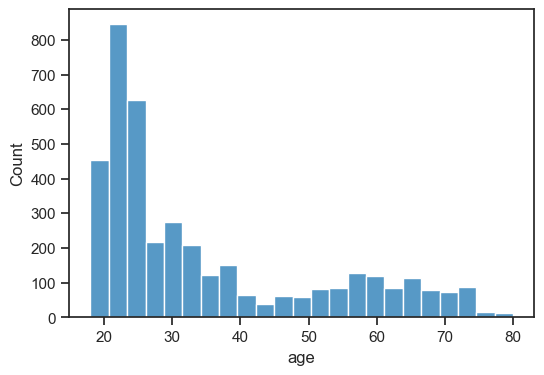

In [142]:
sns.histplot(data=Demographic, x='age')

In [143]:
Demographic.describe(include='O')

,education_level,city,sex
count,4000,4000,4000
unique,5,3,2
top,High School,other,female
freq,1322,1981,2368


## By City

In [144]:
# Average age by city
average_age_by_city = Demographic.groupby('city')['age'].mean()
print("Average age by city:")
print(average_age_by_city)
print()

# Percentage of individuals with dependents by city
percent_dependents_by_city = Demographic.groupby('city')['dependents'].mean() * 100
print("Percentage of individuals with dependents by city:")
print(percent_dependents_by_city)
print()

# Distribution of education levels by city
education_distribution_by_city = Demographic.groupby('city')['education_level'].value_counts(normalize=True) * 100
print("Education level distribution by city:")
print(education_distribution_by_city)


Average age by city:
city
Birmingham    35.475360
London        34.008571
other         34.430086
Name: age, dtype: float64

Percentage of individuals with dependents by city:
city
Birmingham    28.582259
London        27.428571
other         27.460878
Name: dependents, dtype: float64

Education level distribution by city:
city        education_level      
Birmingham  High School              30.629265
            Bachelor                 27.141774
            less than high school    20.166793
            Master                   17.058378
            PhD                       5.003791
London      High School              34.285714
            Bachelor                 24.857143
            less than high school    19.857143
            Master                   17.142857
            PhD                       3.857143
other       High School              34.225139
            Bachelor                 24.785462
            less than high school    20.848057
            Master            

**Very similar patterns accross cities.**

## By sex

In [145]:
# Average age by sex
average_age_by_sex = Demographic.groupby('sex')['age'].mean()
print("Average age by sex:")
print(average_age_by_sex)
print()

# Percentage of individuals with dependents by sex
percent_dependents_by_sex = Demographic.groupby('sex')['dependents'].mean() * 100
print("Percentage of individuals with dependents by sex:")
print(percent_dependents_by_sex)
print()

# Distribution of education levels by sex
education_distribution_by_sex = Demographic.groupby('sex')['education_level'].value_counts(normalize=True) * 100
print("Education level distribution by sex:")
print(education_distribution_by_sex)


Average age by sex:
sex
female    32.160895
male      38.386642
Name: age, dtype: float64

Percentage of individuals with dependents by sex:
sex
female    27.576014
male      28.186275
Name: dependents, dtype: float64

Education level distribution by sex:
sex     education_level      
female  High School              33.192568
        Bachelor                 24.746622
        less than high school    20.777027
        Master                   17.187500
        PhD                       4.096284
male    High School              32.843137
        Bachelor                 26.776961
        less than high school    19.975490
        Master                   15.870098
        PhD                       4.534314
Name: proportion, dtype: float64


**Males are 6 years older then females: 38 vs 32**  

Similar education level and nr of dependents.

## By education level

In [146]:
# Average age by education level
average_age_by_education = Demographic.groupby('education_level')['age'].mean()
print("Average age by education level:")
print(average_age_by_education)
print()

# Percentage of individuals with dependents by education level
percent_dependents_by_education = Demographic.groupby('education_level')['dependents'].mean() * 100
print("Percentage of individuals with dependents by education level:")
print(percent_dependents_by_education)


Average age by education level:
education_level
Bachelor                 35.048876
High School              34.861573
Master                   33.581081
PhD                      35.333333
less than high school    34.786064
Name: age, dtype: float64

Percentage of individuals with dependents by education level:
education_level
Bachelor                 24.437928
High School              28.214826
Master                   21.621622
PhD                      28.070175
less than high school    36.430318
Name: dependents, dtype: float64


**Interestingly, different education levels have the same average age**  

**The lower the education level, the more likely to have dependents.**  
**Exception**: PhD with same proportion of High School  



### Correlation between Age and Having Dependents - no correlation

In [147]:
# Calculate point-biserial correlation
correlation, p_value = stats.pointbiserialr(Demographic['dependents'], Demographic['age'])
print(f"Correlation between age and having dependents: {correlation:.3f}")
print(f"P-value of the correlation: {p_value:.3f}")

Correlation between age and having dependents: 0.004
P-value of the correlation: 0.810


### Age across Education Levels - no difference

In [148]:
groups = Demographic.groupby('education_level')['age'].apply(list)

# Perform ANOVA test
f_stat, p_value = f_oneway(*groups)
print(f"F-statistic: {f_stat:.3f}")
print(f"P-value: {p_value:.3f}")

F-statistic: 0.992
P-value: 0.410


###  Education Level and Dependents - there is a difference

In [149]:
contingency_table = pd.crosstab(Demographic['education_level'], Demographic['dependents'])

# Perform chi-square test
chi2, p, dof, expected = chi2_contingency(contingency_table)
print(f"Chi-square statistic: {chi2:.3f}")
print(f"P-value: {p:.3f}")

Chi-square statistic: 48.873
P-value: 0.000


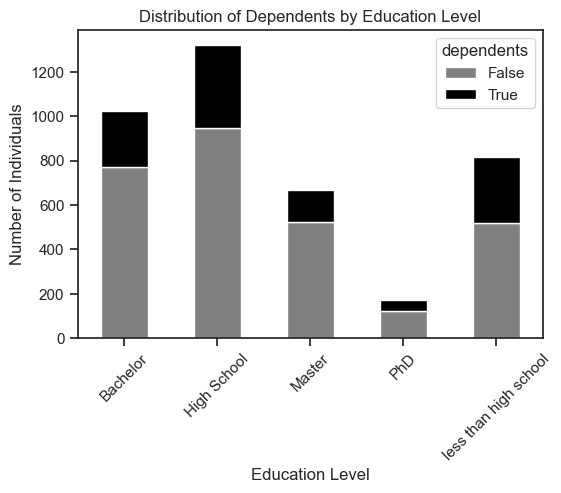

In [150]:
# Plotting a stacked bar graph
contingency_table.plot(kind='bar', stacked=True, color=['gray', 'black'])
plt.title('Distribution of Dependents by Education Level')
plt.xlabel('Education Level')
plt.ylabel('Number of Individuals')
plt.xticks(rotation=45)  # Rotates labels to improve readability
plt.show()

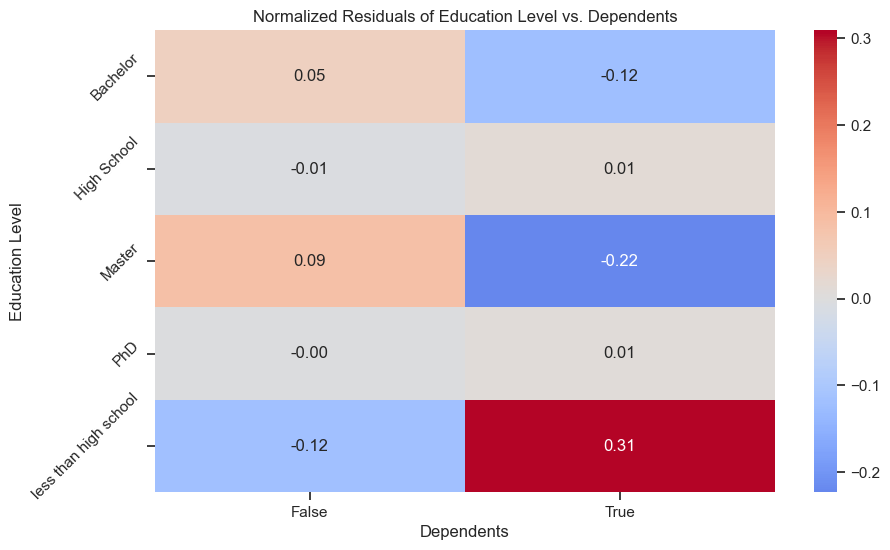

In [151]:
# Calculate the residuals (observed - expected)
residuals = contingency_table - expected

# Normalize residuals by expected
normalized_residuals = residuals / expected

# Plotting a heatmap of the normalized residuals
plt.figure(figsize=(10, 6))
sns.heatmap(normalized_residuals, annot=True, cmap="coolwarm", fmt=".2f", center=0)
plt.title('Normalized Residuals of Education Level vs. Dependents')
plt.xlabel('Dependents')
plt.ylabel('Education Level')
plt.yticks(rotation=45)
plt.show()


**'less than high school'** are **more** likely to have dependents than expected.  

**'Master' and 'Bachelor'** are **less** likely to have children.

In [152]:
Demographic

,education_level,dependents,city,age,sex
Cust_ID,,,,,
4,Master,True,other,22,male
5,High School,False,Birmingham,30,female
6,PhD,True,other,19,female
9,High School,False,other,21,male
10,less than high school,False,other,22,male
...,...,...,...,...,...
6489,Bachelor,False,other,29,female
6491,Master,False,other,28,male
6492,High School,False,Birmingham,20,male


## Export to CSV

In [153]:
Demographic.to_csv('exported_data/demo_clean.csv',index=True)

# Merged Datasets

In [154]:
df_dig_clean.columns

Index(['Email_Clicks', 'SM_Comments', 'App_Clicks', 'SM_Likes', 'SM_Shares',
       'SM_Clicks', 'cluster'],
      dtype='object')

In [155]:
Products_final.columns

Index(['fitness_gym', 'hiking_running', 'teamgames', 'outdooractivities',
       'totalproducts', 'Avg_Spent', 'Days_Since_Last_Purchase',
       'cluster_label'],
      dtype='object')

In [156]:
Demographic.columns

Index(['education_level', 'dependents', 'city', 'age', 'sex'], dtype='object')

In [157]:
merged_dfs = pd.merge(df_dig_clean,Products_final,on='Cust_ID')

In [158]:
merged_dfs['cluster_id'] = merged_dfs['cluster'].astype(str) + merged_dfs['cluster_label'].astype(str)

In [159]:
merged_dfs.drop(['cluster','cluster_label'],axis=1,inplace=True)

In [160]:
merged_dfs = pd.merge(merged_dfs,Demographic,on='Cust_ID')

## Export three merged datasets with clusters

In [161]:
merged_dfs.isna().sum()

Email_Clicks                0
SM_Comments                 0
App_Clicks                  0
SM_Likes                    0
SM_Shares                   0
SM_Clicks                   0
fitness_gym                 0
hiking_running              0
teamgames                   0
outdooractivities           0
totalproducts               0
Avg_Spent                   0
Days_Since_Last_Purchase    0
cluster_id                  0
education_level             0
dependents                  0
city                        0
age                         0
sex                         0
dtype: int64

In [162]:
merged_dfs.to_csv('exported_data/merged_dfs.csv', index=True)